

# **Problem Statement: Sales Forecasting for Rossmann chain of stores**



# **Data Acquisition**

**Installing and importing all the necessary libraries**

In [105]:
# prophet by Facebook
!pip install prophet

In [106]:
import warnings
warnings.filterwarnings("ignore")

# loading packages: basic + dates
import numpy as np
import pandas as pd
import datetime

# data visualization
import matplotlib.pyplot as plt

# advanced data visualization
import seaborn as sns
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
import prophet

**Importing the dataset**

In [107]:
# importing train data to learn
train = pd.read_csv("train.csv",parse_dates = True, low_memory = False, index_col = 'Date')

# ensure the index is a DatetimeIndex
train.index = pd.to_datetime(train.index)

# additional store data
store = pd.read_csv("store.csv",low_memory = False)

# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

# **Data Preprocessing**

In [108]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5)

In total:  (1017209, 8)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1

## **Data Extraction**

In [109]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

## **Data Visualization  before Processing**

ECDF plots to check presence of records with extremely low daily sales, customers and sales per customer

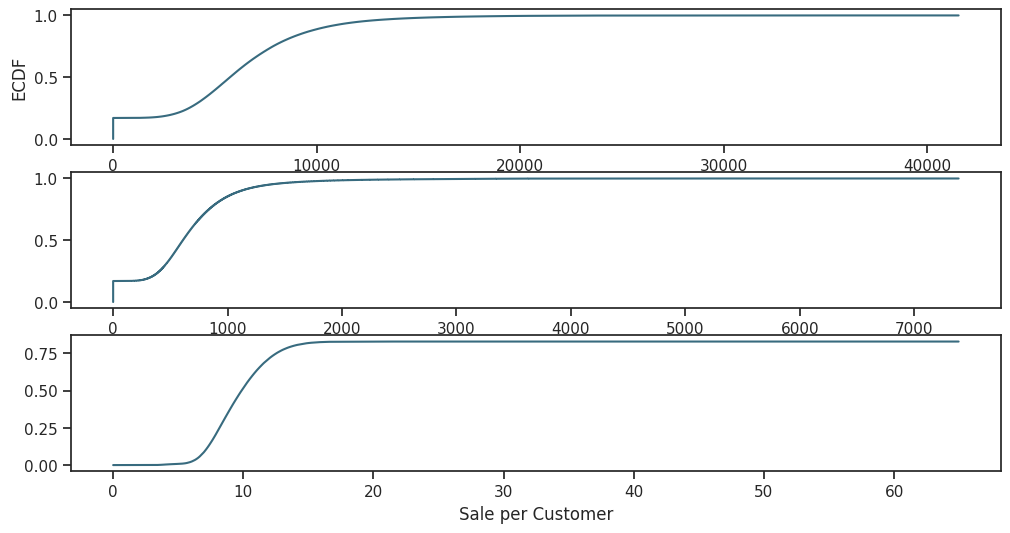

In [110]:
sns.set(style = "ticks")# to format into seaborn
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

## **Data Cleaning**

### **Outlier detection and treatment**

In [111]:
def mad_based_outlier(points, thresh=3.5):
    '''
    This function will calculate mean absolute deviation and return true or
    false based on points which have MAD greater than threshold provided.
    '''
    # Convert Pandas Series to a NumPy array before reshaping
    if len(points.shape) == 1:
        points = points.to_numpy()[:, None]  # Convert to NumPy array
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [112]:
#Creating new column 'Outlier' which tells whether a point is outlier or not.
for i in train['Store'].unique():
    train.loc[(train['Store'] == i) & (train['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(train.loc[(train['Store'] == i) & (train['Open'] == 1)]['Sales'], 3.5)

In [113]:
#Removing all the outliers including the closed stores which have no contribution towards sales
train = train.loc[train['Outlier']==False].drop('Outlier', axis=1)

In [114]:
train.shape

(837967, 13)

### **Handling missing values and inconsistencies**

In [115]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (27, 13)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-03-26    674          4      0          0     1      0            0   
2014-10-01    708          3      0          0     1      1            0   
2014-09-05    548          5      0          0     1      1            0   
2014-09-04     28          4      0          0     1      1            0   
2014-09-03     28          3      0          0     1      1            0   

            SchoolHoliday  Year  Month  Day  WeekOfYear  SalePerCustomer  
Date                                                                      
2015-03-26              0  2015      3   26          13              NaN  
2014-10-01              0  2014     10    1          40              NaN  
2014-09-05              1  2014      9    5          36              NaN  
2014-09-04              0  2014      9    4          36              NaN  
2014-09-03              1  2014      9    3          36              NaN

In [116]:
# handling the inconsistencies
print("Days which didn't have any sales won't be counted into the forecasts.")
train = train[(train['Sales'] != 0)]

print("In total: ", train.shape)

Days which didn't have any sales won't be counted into the forecasts.
In total:  (837940, 13)


In [117]:
# additional information about the stores
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [118]:
# missing values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

**Dealing with the missing values of Promo2 related columns after proper reasoning**

In [119]:
# check if number of rows where Promo2 is 0 is the same as number of rows where Promo2Since[Week/Year] and PromoInterval is null
store[(store["Promo2"] == 0)].shape

(544, 10)

In [120]:
# no promo = no information about the promoweek?
a = store[pd.isnull(store.Promo2SinceWeek)]
print(a[a.Promo2 != 0].shape)

# no promo = no information about the promoyear?
b = store[pd.isnull(store.Promo2SinceYear)]
print(b[b.Promo2 != 0].shape)

# no promo = no information about the promointerval?
c = store[pd.isnull(store.PromoInterval)]
print(c[c.Promo2 != 0].shape)

(0, 10)
(0, 10)
(0, 10)


In [121]:
# for rows with Promo2 as 0, replace the null values of Promo2Since[Week/Year] and PromoInterval with 0 assuming no info available
store.loc[store['Promo2'] == 0, 'Promo2SinceWeek'] = 0
store.loc[store['Promo2'] == 0, 'Promo2SinceYear'] = 0
store.loc[store['Promo2'] == 0, 'PromoInterval'] = 0

**Dealing with the missing values of Competitor related columns**

In [122]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              0.0              0.0                0  
621              0.0              0.0                0  
878              5.0           2013.0  Feb,May,Aug,Nov

Approach 1: Filling missing values of CompetitionDistance with a large number to represent no competitor stores nearby

In [123]:
# Assuming a high value (e.g., 99999) represents no competition
high_value_for_no_competition = 99999

# Replace missing values with the high value
store['CompetitionDistance'].fillna(high_value_for_no_competition, inplace=True)

Approach 2: Filling missing value of CompetitionDistance with median values after checking skewness of the dataset

In [124]:
'''
# Checking skewness of the CompetitionDistance column

import scipy.stats as stats

# Visual Inspection with Histogram
plt.figure(figsize=(10, 6))
plt.hist(store['CompetitionDistance'].dropna(), bins=30, edgecolor='k')
plt.xlabel('Competition Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Competition Distance')
plt.show()

# Statistical Measure: Skewness
skewness = store['CompetitionDistance'].dropna().skew()
print(f'Skewness: {skewness}')
'''

"\n# Checking skewness of the CompetitionDistance column\n\nimport scipy.stats as stats\n\n# Visual Inspection with Histogram\nplt.figure(figsize=(10, 6))\nplt.hist(store['CompetitionDistance'].dropna(), bins=30, edgecolor='k')\nplt.xlabel('Competition Distance')\nplt.ylabel('Frequency')\nplt.title('Histogram of Competition Distance')\nplt.show()\n\n# Statistical Measure: Skewness\nskewness = store['CompetitionDistance'].dropna().skew()\nprint(f'Skewness: {skewness}')\n"

In [125]:
'''
# fill NaN with a median value (due to skewed distribuion and large dataset)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
'''

"\n# fill NaN with a median value (due to skewed distribuion and large dataset)\nstore['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)\n"

In [126]:
# Replace null values in CompetitionOpenSinceMonth and CompetitionOpenSinceYear with 0 assuming info not available
store['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
store['CompetitionOpenSinceYear'].fillna(0, inplace=True)

In [127]:
# ensuring no missing values are present
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

## **Data Visualization after Processing**

**ECDF plots to check presence of records with extremely low daily sales, customers and sales per customer**

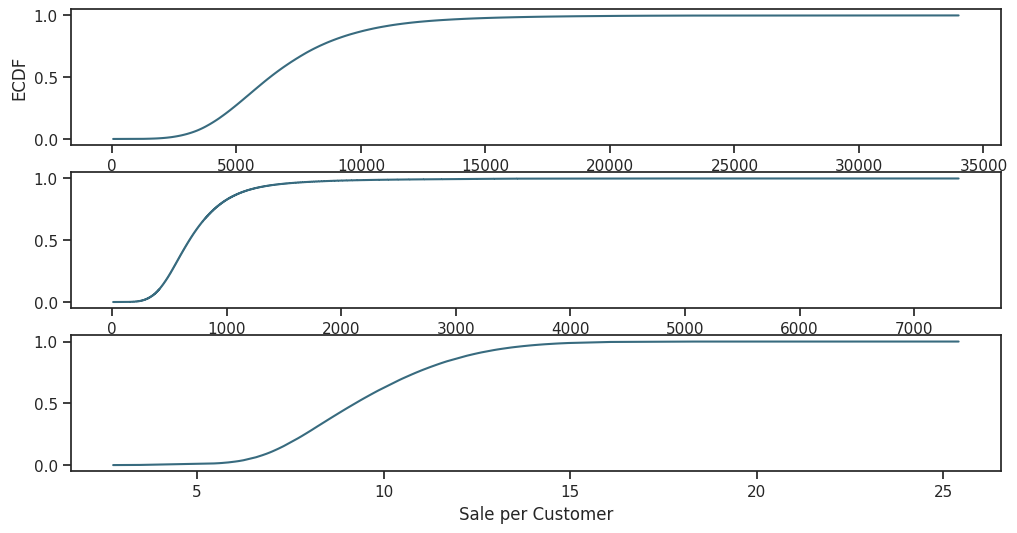

In [128]:
sns.set(style = "ticks")# to format into seaborn
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

# **Exploratory Data Analysis**

## **Overall sales of all the stores combined on yearly, monthly, daily and day of the week basis**

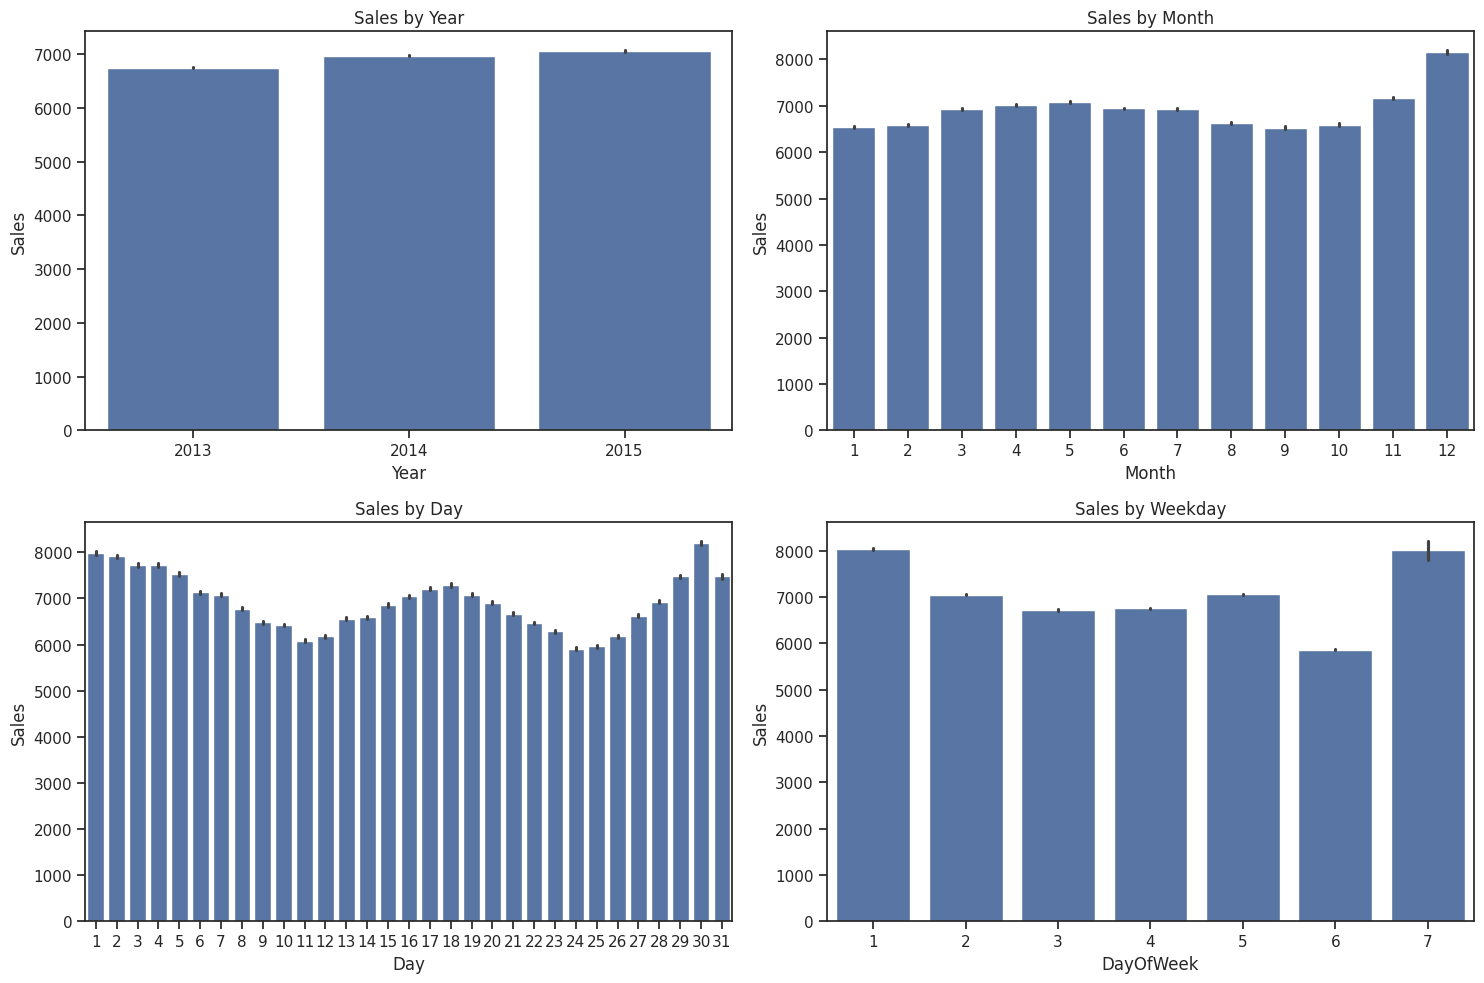

In [129]:
# Create a grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(x='Year',y="Sales", data=train, ax=axes[0, 0])
sns.barplot(x='Month',y="Sales", data=train, ax=axes[0, 1])
sns.barplot(x='Day',y="Sales", data=train, ax=axes[1, 0])
sns.barplot(x='DayOfWeek',y="Sales", data=train, ax=axes[1, 1])

# Set the titles for each chart
axes[0, 0].set_title('Sales by Year')
axes[0, 1].set_title('Sales by Month')
axes[1, 0].set_title('Sales by Day')
axes[1, 1].set_title('Sales by Weekday')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of bar charts
plt.show()

Insights:

1. Sales increase over the years
2. Sales is maximum in the month of Nov and Dec
3. Sales increase on Mondays and Sundays
4. Sales in a month is maximum at the start and end of the month

## **Statistical details of overall sales**

In [130]:
def histograms(df,col_name,bins_number=100,diff=False, xmin=-1000, xmax=1000):
    if diff:
        plt.figure(figsize=(8,6))
        plt.hist(df[col_name].diff(),bins=bins_number)
        plt.xlim(xmin,xmax)
        plt.show()
    else:
        plt.figure(figsize=(8,6))
        plt.hist(df[col_name],bins=bins_number)
        plt.show()

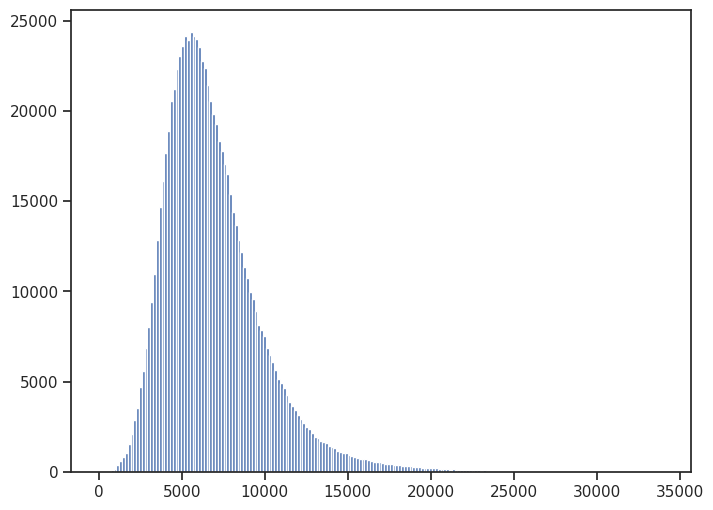

In [131]:
histograms(train,"Sales",bins_number=200,diff=False)

In [132]:
train["Sales"].describe()

count    837940.000000
mean       6903.090189
std        3025.771655
min          46.000000
25%        4848.000000
50%        6345.000000
75%        8307.000000
max       34001.000000
Name: Sales, dtype: float64

In [133]:
def most_common_sales_range(df, col_name, bins_number=100):
    # Extract the data column
    sales_data = df[col_name].dropna()

    # Calculate the histogram
    counts, bin_edges = np.histogram(sales_data, bins=bins_number)

    # Find the bin with the highest frequency
    max_count_index = np.argmax(counts)
    most_common_range = (bin_edges[max_count_index], bin_edges[max_count_index + 1])

    return most_common_range

# Example usage with the train DataFrame
# Assuming 'train' DataFrame is already loaded and contains the 'Sales' column
most_common_range = most_common_sales_range(train, 'Sales', bins_number=200)
print(f'The most common sales range is: {most_common_range[0]:.2f} - {most_common_range[1]:.2f}')


The most common sales range is: 5478.80 - 5648.57


Insights:

1. Sales data is normally distributed
2. Few stores with very high sales
3. The average sales value is 6903.090189
4. The most frequent sales range is 5478.80 - 5648.57

## **Statistical details of sales in different store types**

**Joining the train and store datasets**

In [134]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (837940, 22)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  Year  Month  ...  SalePerCustomer  StoreType  Assortment  \
0              1  2015      7  ...         9.482883          c           a   
1              1  2015      7  ...         9.194139          c           a   
2              1  2015      7  ...         9.143403          c           a   
3              1  2015      7  ...         8.948214          c           a   
4              1  2015      7  ...         9.970588          c           a   

  CompetitionDistance CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0              1270.0                       9.0                    2008.0   
1              1270.0                       9.0                    2008.0   
2              1270.0                       9.0                    2008.0   
3              1270.0                       9.0                    2008.0   
4              1270.0                       9.0                    2008.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear  PromoInterval  
0       0              0.0              0.0              0  
1       0              0.0              0.0              0  
2       0              0.0              0.0              0  
3       0              0.0              0.0              0  
4       0              0.0              0.0              0  

[5 rows x 22 columns]

In [135]:
train_store.groupby('StoreType')['Sales'].describe()

count          mean          std     min     25%     50%  \
StoreType                                                                
a          453985.0   6878.091492  3209.607655    46.0  4686.0  6262.0   
b           15298.0  10159.074127  5021.912685  1252.0  6309.0  9119.0   
c          111890.0   6863.973831  2788.496973   506.0  4902.0  6380.0   
d          256767.0   6770.346185  2474.221934   582.0  5040.0  6373.0   

               75%      max  
StoreType                    
a           8355.0  34001.0  
b          13102.0  31406.0  
c           8284.0  25662.0  
d           8074.0  30169.0

Insight:
1. StoreType B has the highest average of Sales followed by StoreType A, C and D in the same order
2. The data for StoreType B is very less

## **Distribution of sales and customers in different store types**

In [136]:
train_store.groupby('StoreType')[['Customers', 'Sales']].sum()

Customers       Sales
StoreType                       
a          359454226  3122550366
b           30839336   155413516
c           90620912   768010032
d          154900725  1738401479

Insights:
1. StoreType A have max customers and sales
2. StoreType D goes on the second place in both Sales and Customers

## **Variation of sales, customer and sales per customer for every possible store type and promotion status**

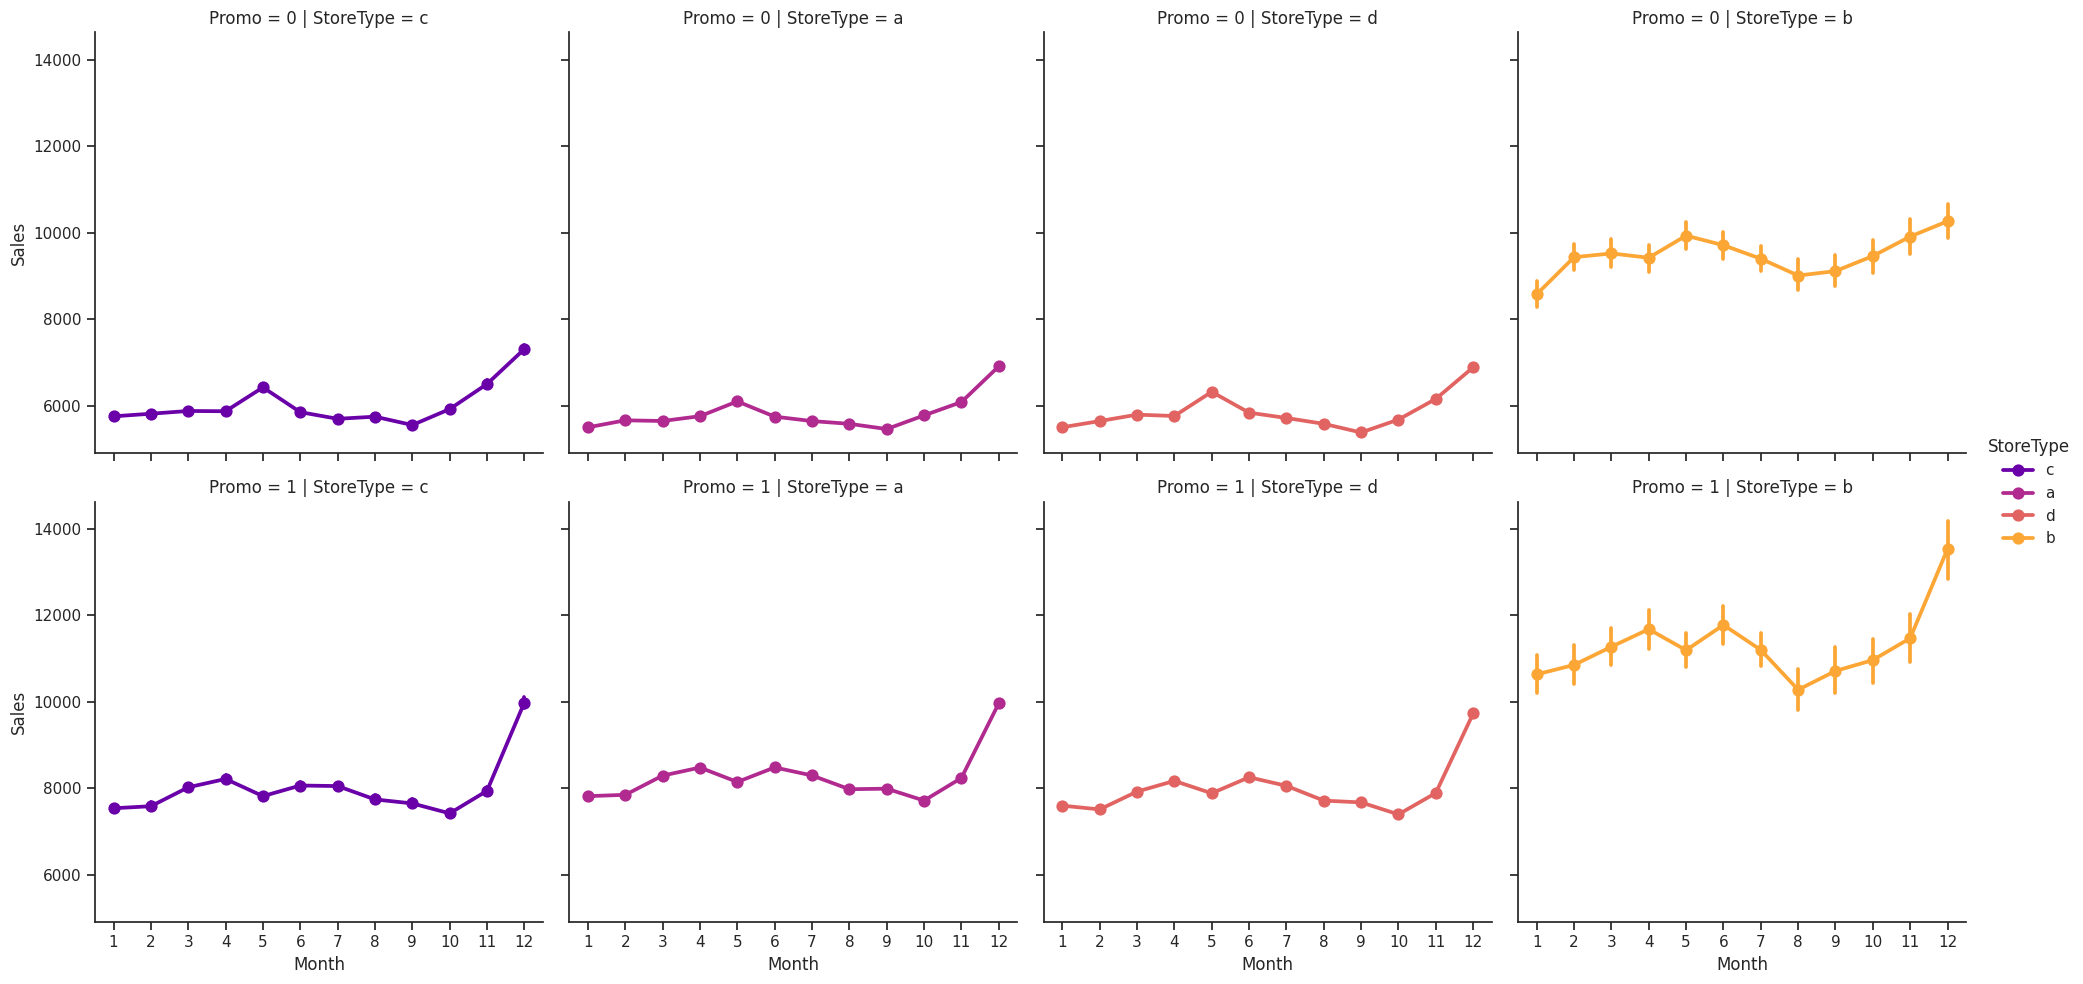

In [137]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Sales",
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               kind='point', # Use a point plot to show trends
               row = 'Promo') # per promo in the store in rows

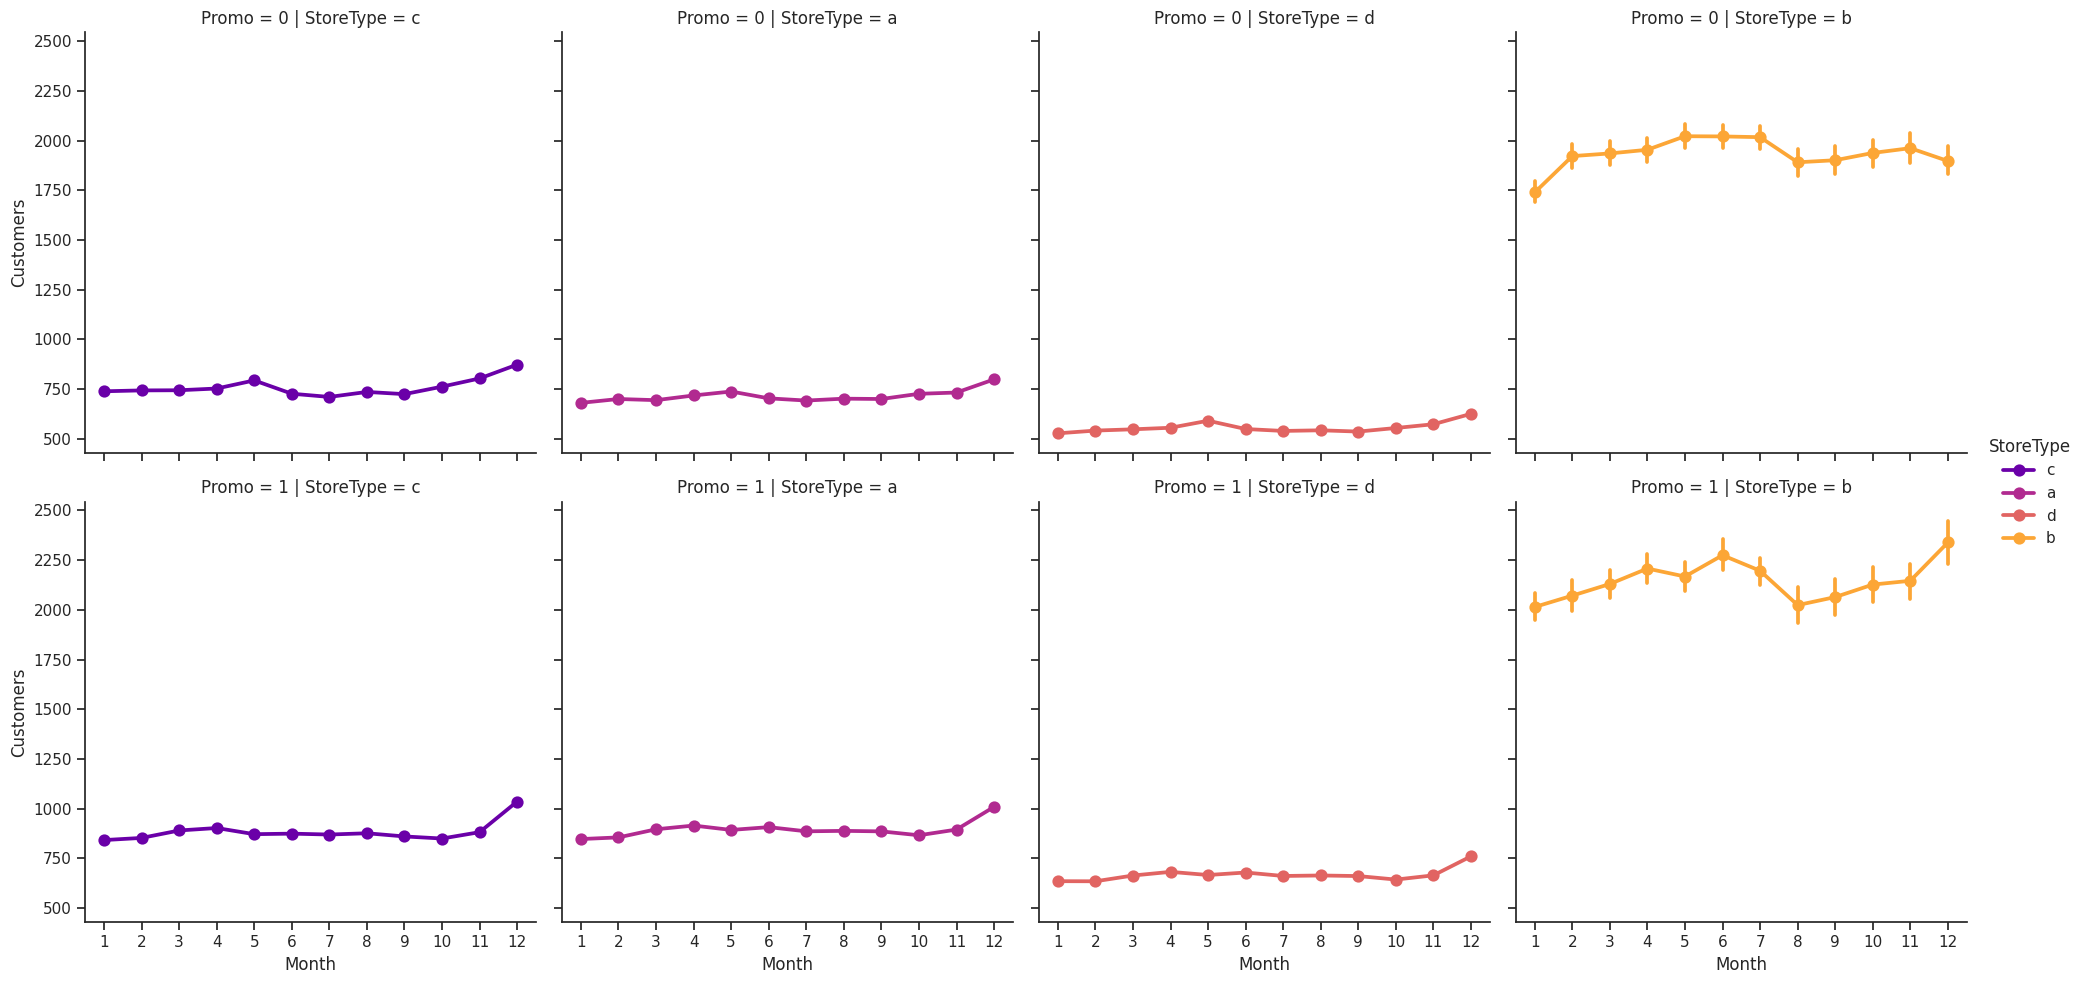

In [138]:
# customer trends
sns.catplot(data = train_store, x = 'Month', y = "Customers",
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               kind='point', # Use a point plot to show trends
               row = 'Promo', # per promo in the store in rows
               color = c)

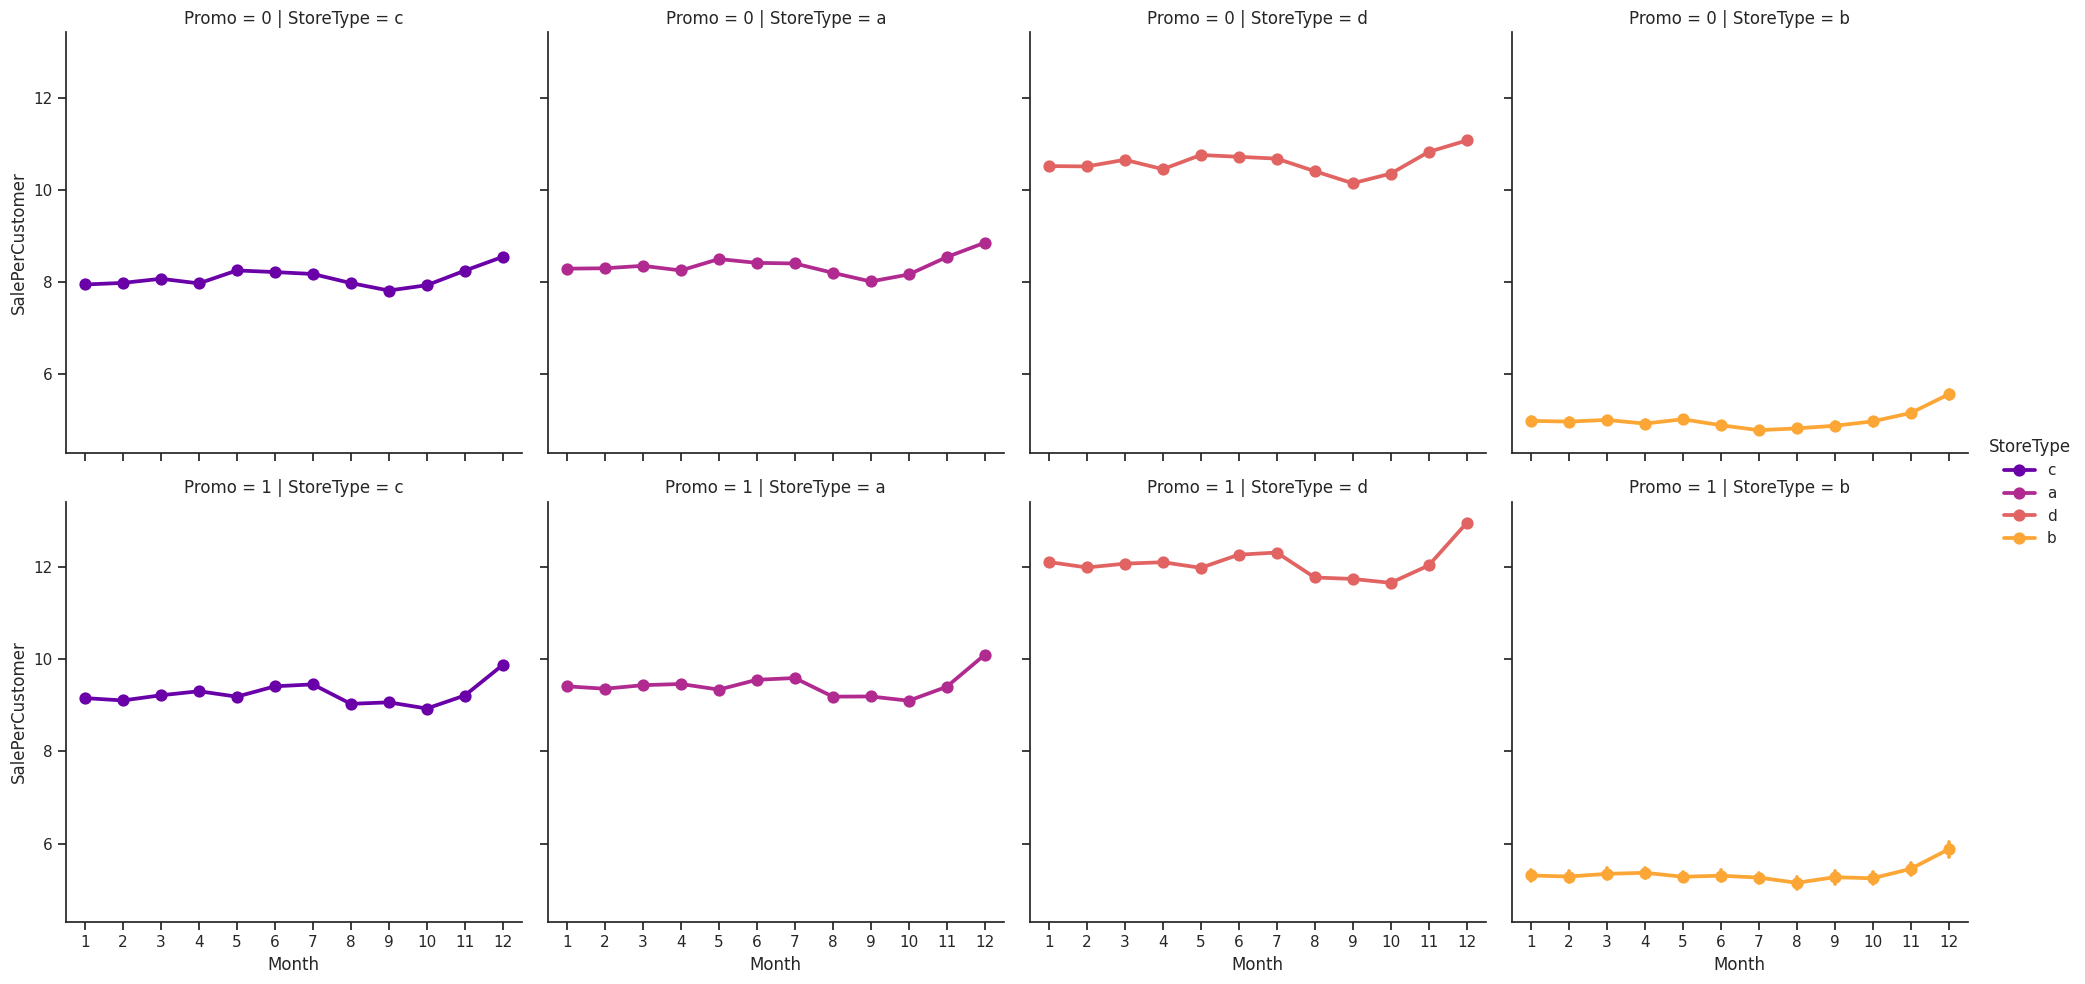

In [139]:
# sale per customer trends
sns.catplot(data = train_store, x = 'Month', y = "SalePerCustomer",
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               kind='point', # Use a point plot to show trends
               row = 'Promo', # per promo in the store in rows
               color = c)

Insights:
1. The sales, customers and sales per customer increases whenever the store is participating in promotions
2. For StoreType B the sales and customers are always significantly more than the other StoreTypes, however the sales per customer value is very low indicating that the customers of B are typically low-end shoppers
3. The highest sales per customer is observed at the StoreType D which tells that its customer base comprises of high-end shoppers

## **Checking operationality of store for every day of the week for each month and all possible store types**

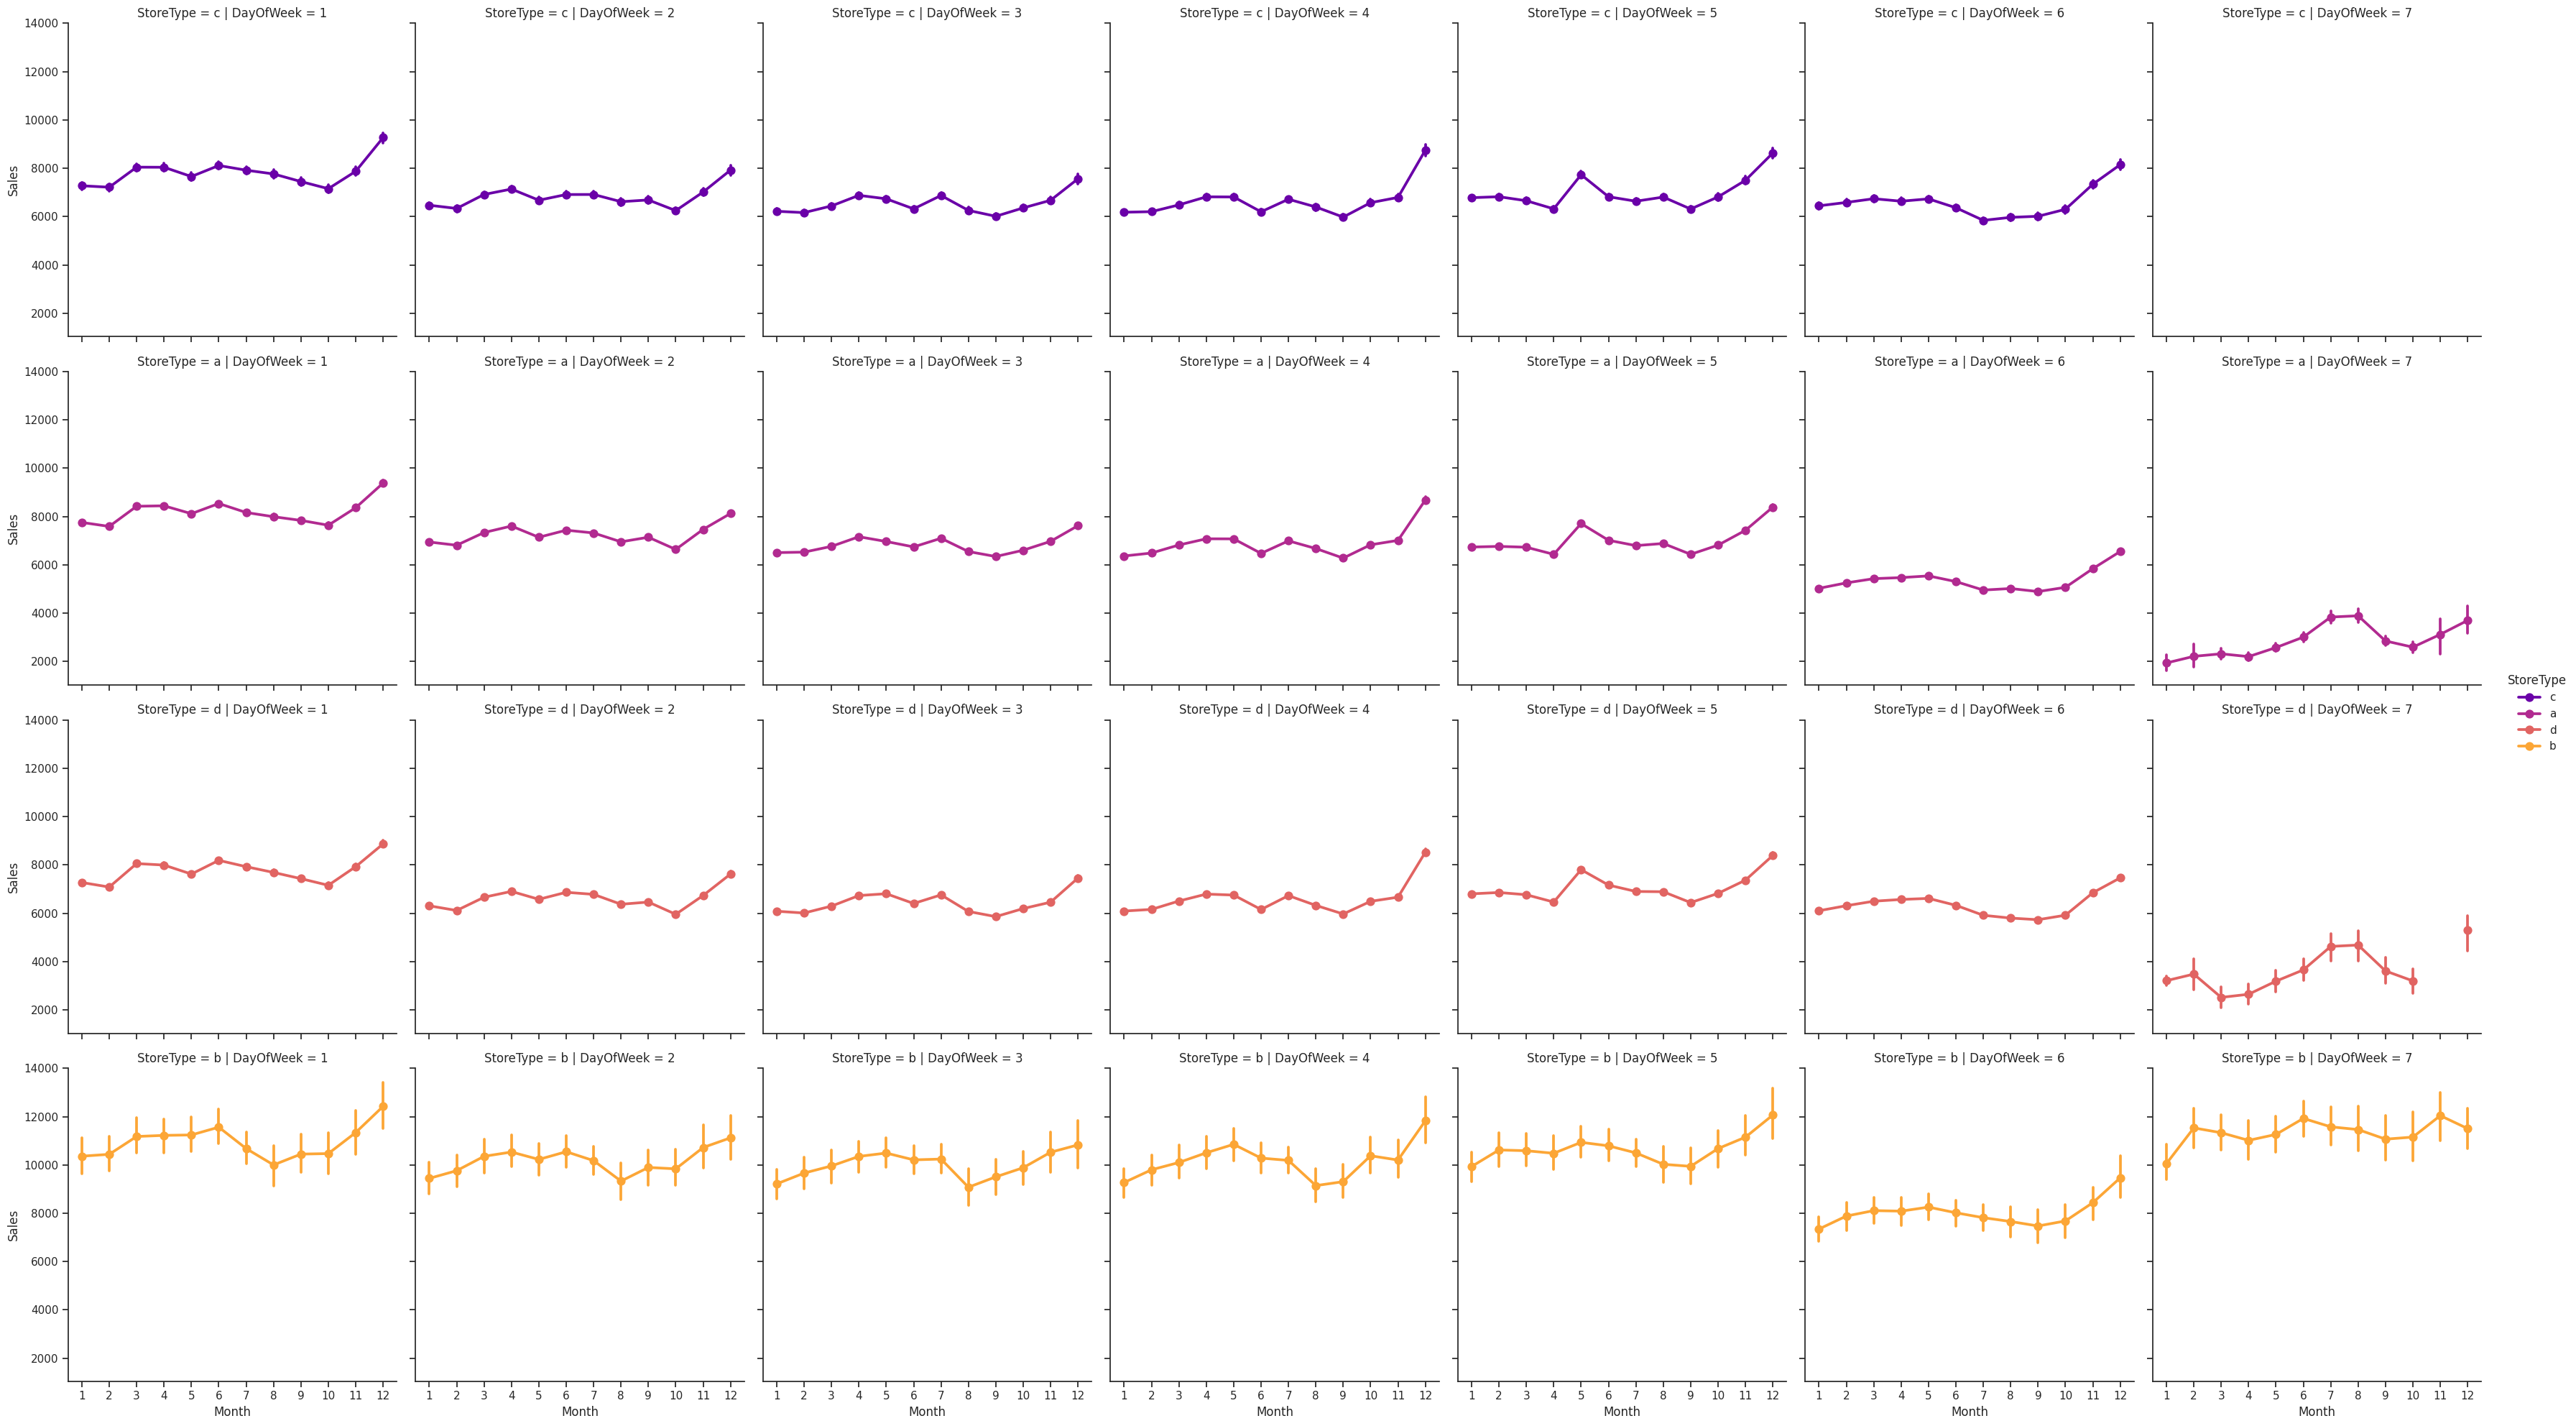

In [140]:
# customers
sns.catplot(data = train_store, x = 'Month', y = "Sales",
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               kind='point', # Use a point plot to show trends
               row = 'StoreType', # per store type in rows
               color = c)

In [141]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  299,  310,  335,  353,  423,  433,
        453,  494,  512,  524,  530,  562,  578,  676,  682,  732,  733,
        769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099,  274])

Insights:
1. StoreType C are all closed on Sundays
2. StoreType D are closed on Sundays only from October to December
3. The sales is maximum at the start of the week and declines slightly over the week for all StoreTypes except B

## **Checking promotion running period and exposure to competition for each store type**

**Data extraction and transformation**

In [142]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)

# Promo open time (in months)
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

**Average PromoOpen time and CompetitionOpen time per store type**

In [143]:
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

Sales    Customers     PromoOpen  CompetitionOpen
StoreType                                                          
a           6878.091492   791.775556   12919.40978      7109.012943
b          10159.074127  2015.906393  17269.331481     11343.826317
c           6863.973831   809.910734  12153.569298      6756.538180
d           6770.346185   603.273493  10420.063777      9028.376645

Insights:
1. The most selling and crowded StoreType A doesn't appear to be the one the most exposed to competitors
2. StoreType B has the longest running period of promotion has been exposed to competitors the longest

## **Correlations analysis**

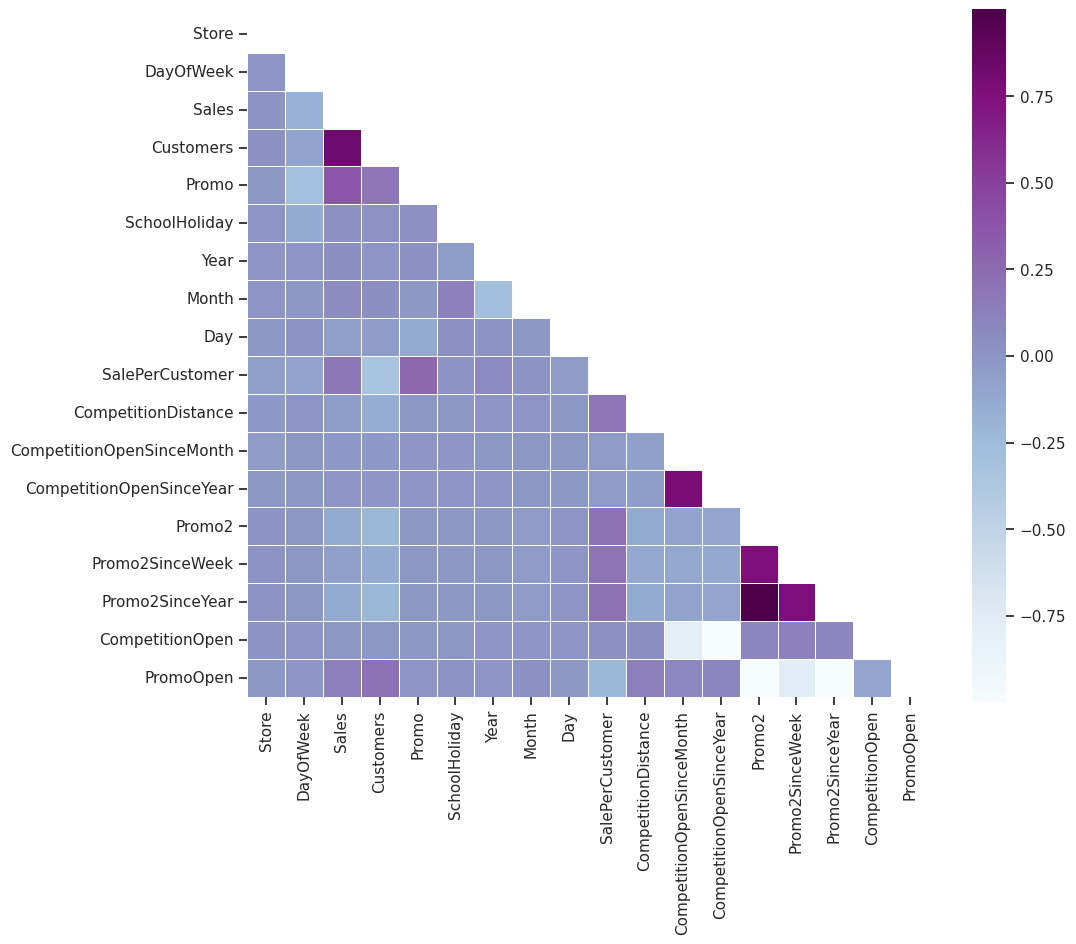

In [144]:
# Compute the correlation matrix
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).select_dtypes(include=['float', 'int']).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")
plt.show()

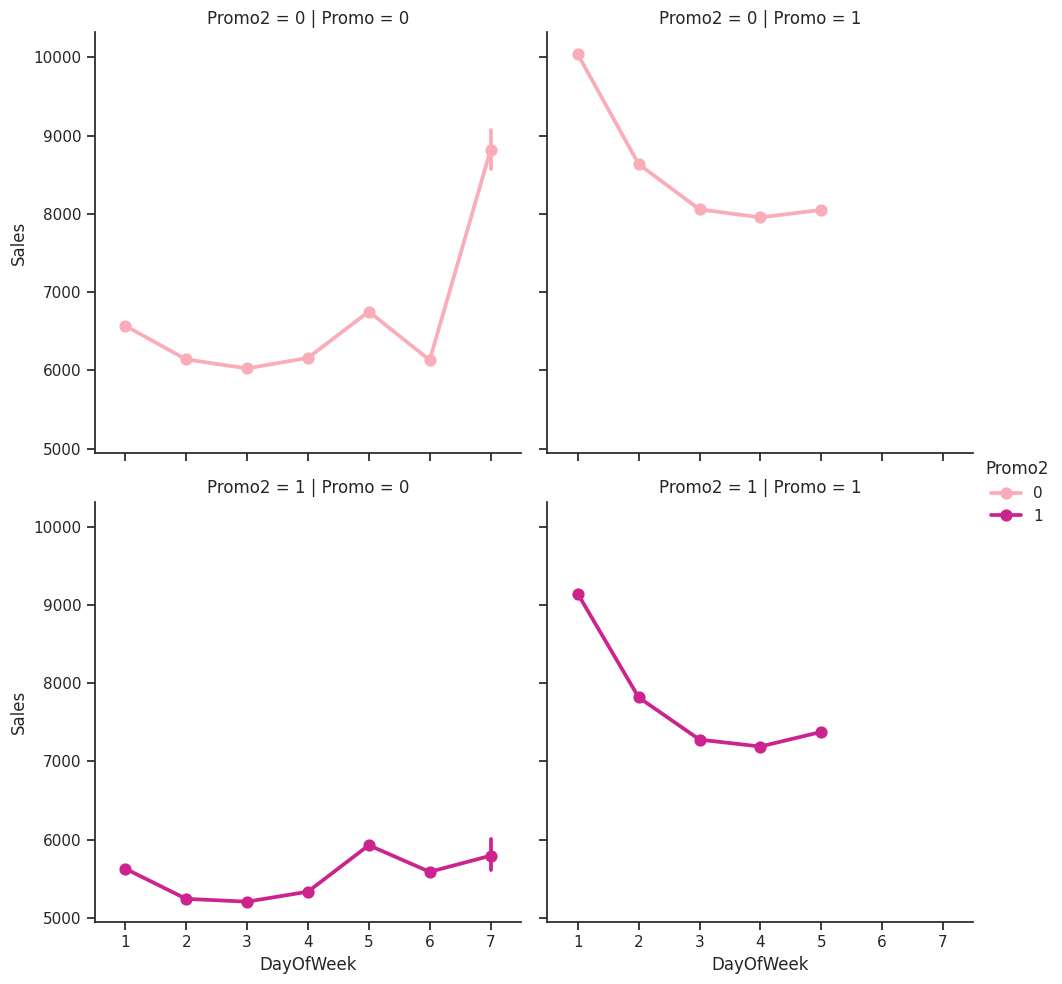

In [145]:
# sale per customer trends
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales",
               col = 'Promo',
               row = 'Promo2',
               hue = 'Promo2',
               kind='point', # Use a point plot to show trends
               palette = 'RdPu')

Insights:
1. There is a strong positive correlation between Sales & Customers, Promo & Customers and Promo & Sales (which is crucial for multivariate analysis to be done later)
2. We observe that if a store continues on with the promotion (Promo2 equal to 1) the number of Customers and Sales seems to stay the same
3. In case of no promotion at all, Sales tend to peak on Sunday (StoreType A, B and D)
4. Stores that run the promotion tend to make most of the Sales on Monday

## **Conclusion of EDA**

1. **Optimize Resources for Peak Periods**: Allocate staff scheduling, high inventory levels, marketing campaigns, and advertising budgets to November and December to maximize revenue. Apply the same strategy to Mondays and Sundays, which experience the highest sales.

2. **Target Budget-Conscious Shoppers in StoreType B**: StoreType B exhibits low sales per customer, indicating a budget-conscious clientele. Tailor marketing efforts with budget-friendly deals to attract and retain these shoppers.

3. **Leverage Success of StoreType A**: StoreType A is the most popular and crowded, performing exceptionally well without significant competition. Analyze the success factors of StoreType A and implement similar strategies across other store types to enhance overall performance.

4. **Boost Sales with Targeted Promotions**: Sales, customer traffic, and sales per customer significantly increase during promotional days. In the absence of promotions, Sundays achieve the highest sales. Use this insight to strategically plan promotions.

5. **Reassess Long-Term Promotions in StoreType B**: StoreType B has the longest promotion periods and faces the most competition. Evaluate the effectiveness of extended promotions and adjust strategies to enhance competitiveness.

6. **Maximize High Buyer Cart in StoreType D**: StoreType D boasts the highest sales per customer, indicating larger buyer carts. Rossmann can capitalize on this by offering a wider variety of products to encourage even higher spending.

7. **Reevaluate Continuous Promotions**: Continuous promotions do not significantly boost sales. Consider adjusting the frequency and duration of promotions to optimize their impact.

# **Time Series Properties Analysis**

## **Seasonality for each store type**

**1. Seasonality of each store type is being checked by taking their representatives**

**2. The data is aggregated from days to weeks**

<Axes: xlabel='Date'>

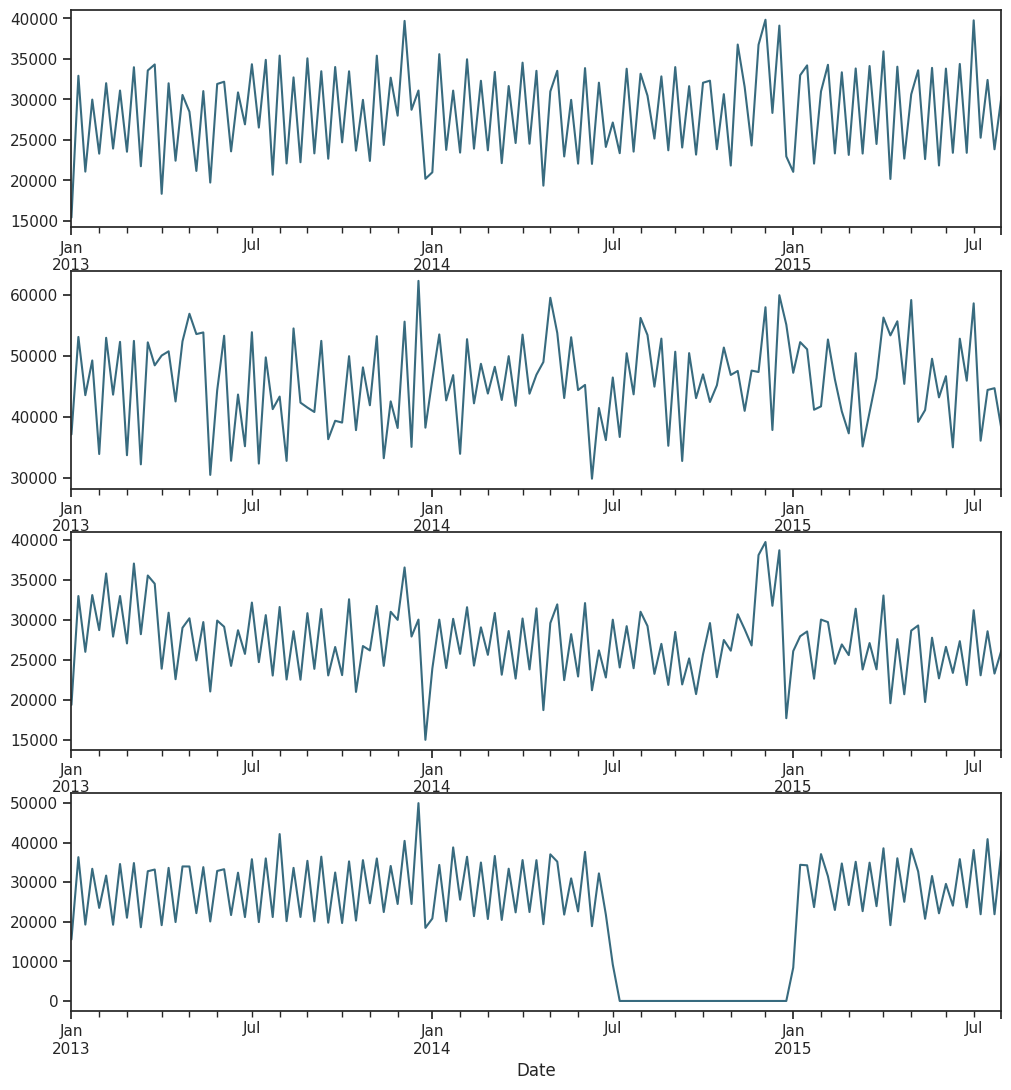

In [146]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types

c = '#386B7F'

sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

Sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays.

## **Trend for each store type**

1. Trend of each store type is being checked by taking their representatives
2. The data is aggregated to months

<Axes: xlabel='Date'>

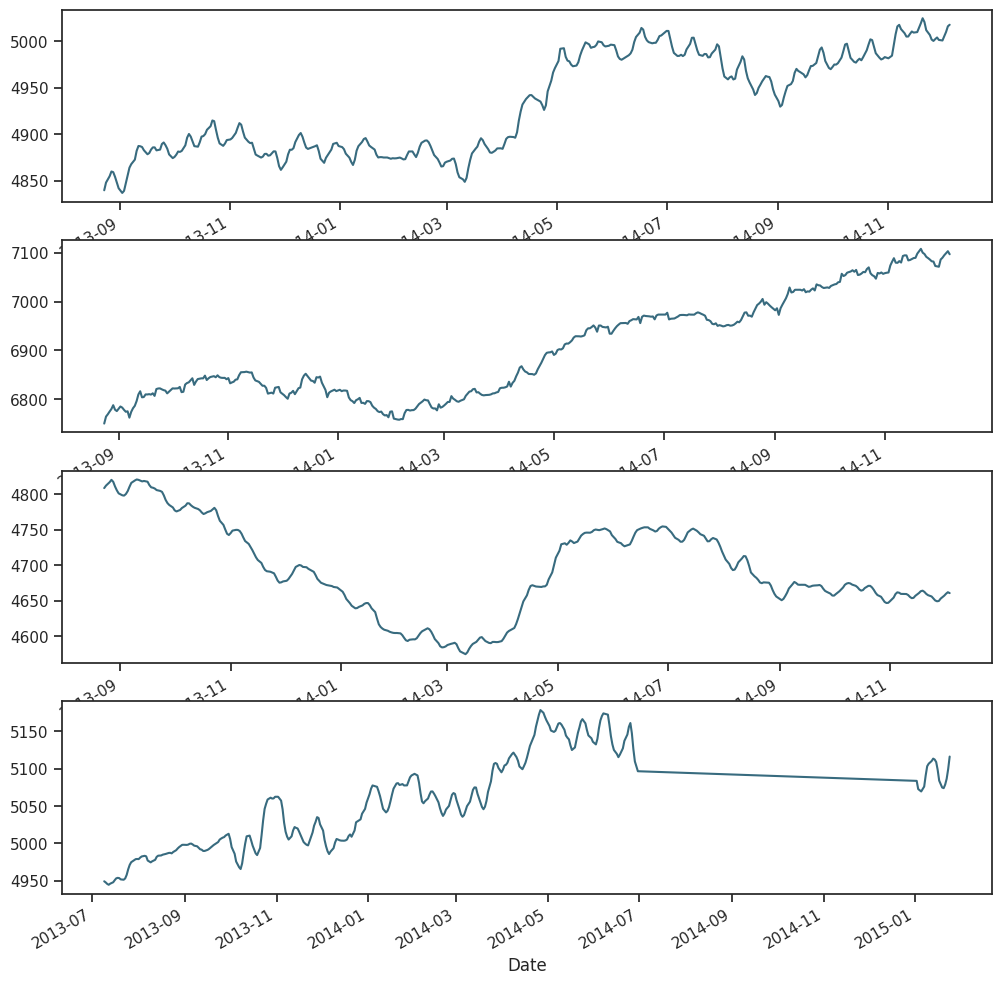

In [147]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', period = int(len(sales_a)/2))
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', period = int(len(sales_b)/2))
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', period = int(len(sales_c)/2))
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', period = int(len(sales_d)/2))
decomposition_d.trend.plot(color = c, ax = ax4)

Overall sales seems to increase, however not for the StoreType C (a third from the top).

## **ACF and PACF plots for each store type**

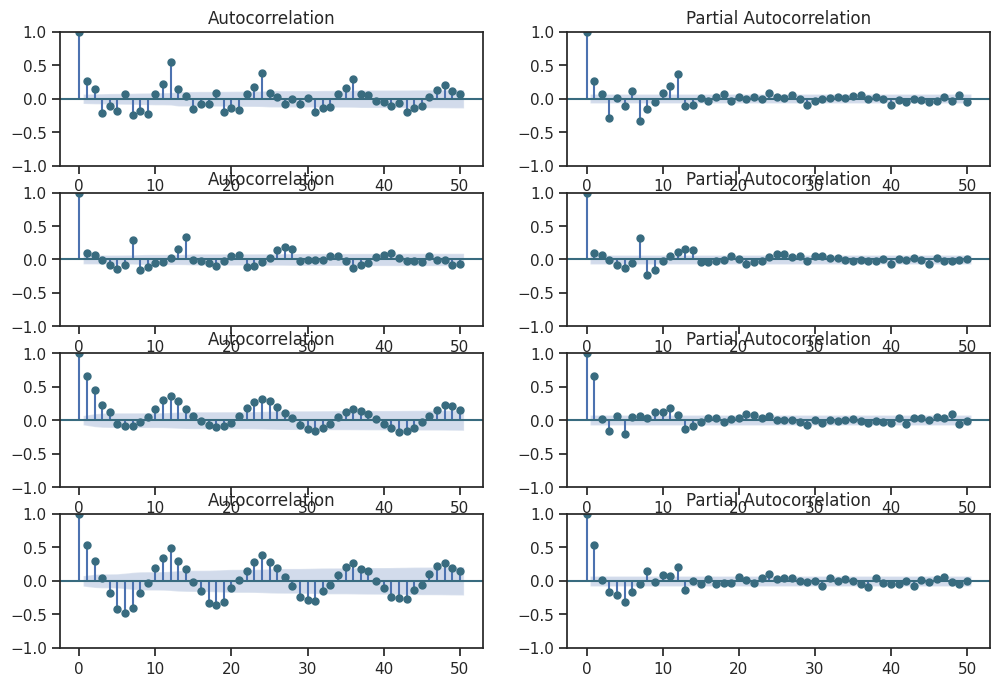

In [148]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

Here StoreType A and B show seasonalities at certain lags. For type A, it is each 12th observation and for type B it's a weekly trend with positives spikes at each 7th observation

# **Time Series Modelling**

In [149]:
!pip install statsforecast

In [150]:
#First import StatsForecast library itself
from statsforecast import StatsForecast

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
#Import the models
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, SimpleExponentialSmoothing, SimpleExponentialSmoothingOptimized, Holt, HoltWinters, DynamicOptimizedTheta, AutoARIMA

#Import evaluation metrics from scikit-learn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

#Then other import statements come
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **Univariate Forecasting**

### **Base Models Forecasting (Average, Naive, Seasonal Naive, Drift, SES, HLT, HWM, Theta)**

In [151]:
# taking a specific storetype's data (store type B)
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
temp = train.copy()

sales_b.rename_axis(index='ds', inplace=True)  # Rename index to 'ds'
sales_b.name = 'y'
sales = sales_b.to_frame(name='y')  # Rename the Series to 'y'
sales.reset_index(inplace=True)

# Set the 'ds' column as the index
sales.set_index('ds', inplace=True)

#Setting unique_id as 1
sales["unique_id"] = "1"
sales = sales.reset_index()

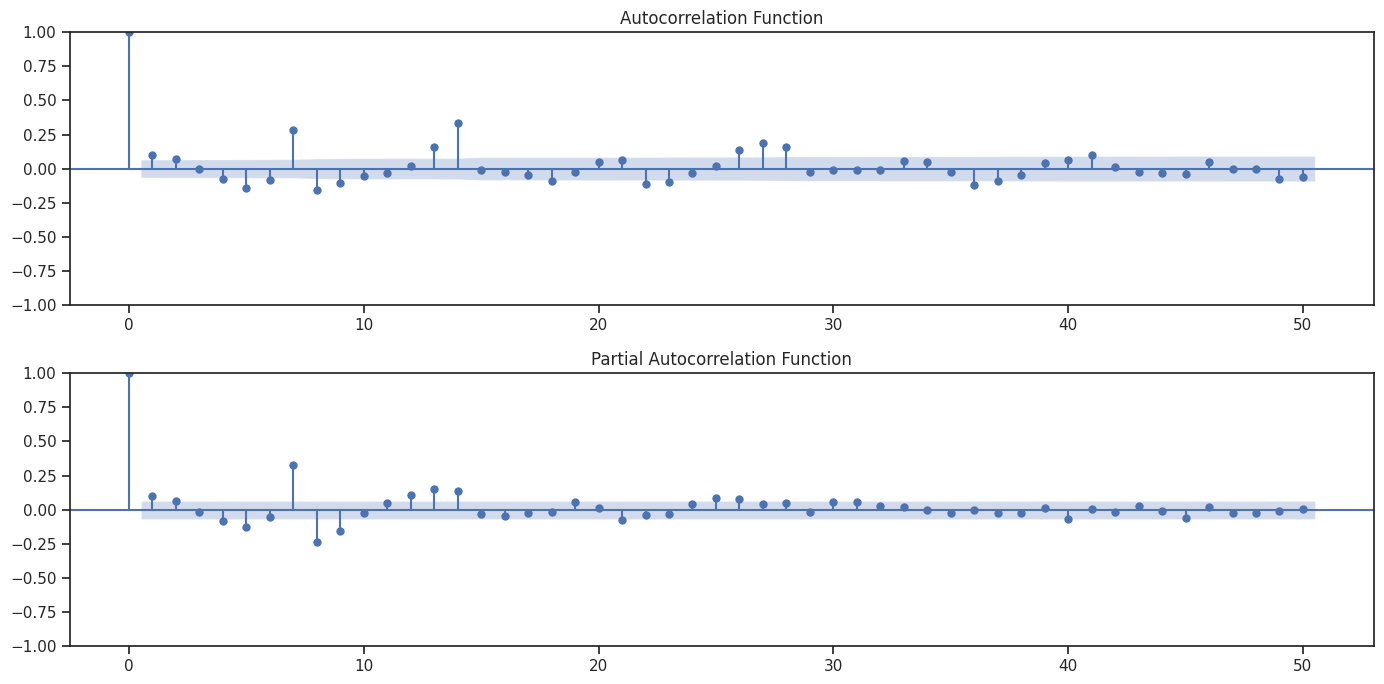

In [55]:
# Plot ACF and PACF
plt.figure(figsize=(14, 7))

plt.subplot(211)
plot_acf(sales['y'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(212)
plot_pacf(sales['y'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

**From this we can infer that seasonality is 7**

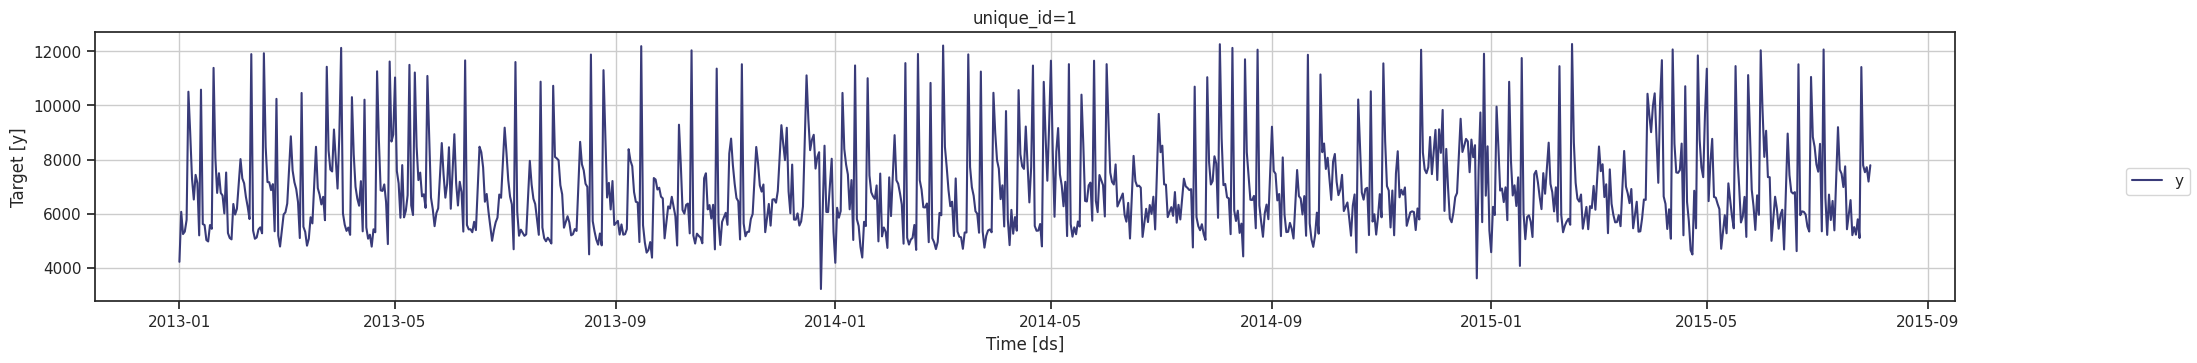

In [56]:
#Plotting the data
StatsForecast.plot(sales)

In [57]:
#train test split
train_size = int(len(sales) * 0.8)
train_df, test_df = sales[:train_size], sales[train_size:]

In [58]:
train_df

ds        y unique_id
0   2013-01-01   4220.0         1
1   2013-01-02   6069.0         1
2   2013-01-03   5246.0         1
3   2013-01-04   5339.0         1
4   2013-01-05   5774.0         1
..         ...      ...       ...
707 2015-01-16   7343.0         1
708 2015-01-17   4068.0         1
709 2015-01-18  11754.0         1
710 2015-01-19   6038.0         1
711 2015-01-20   5057.0         1

[712 rows x 3 columns]

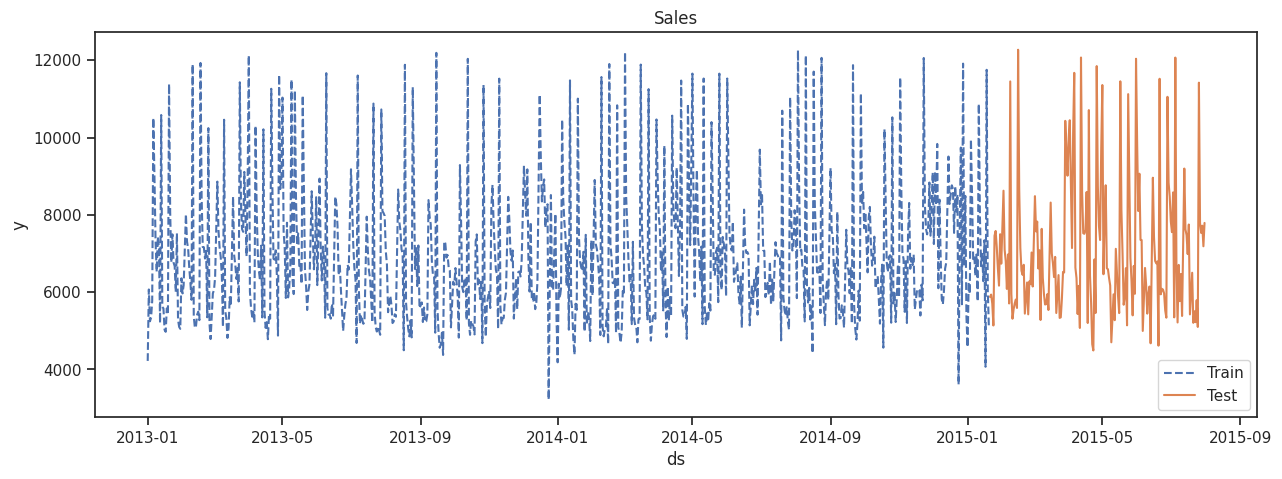

In [59]:
#Plot training and testing data using Seaborn
plt.figure(figsize=(15,5))
sns.lineplot(data=train_df,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(data=test_df, x="ds", y="y", label="Test")
plt.title("Sales");
plt.show()

In [60]:
#Forecast horizon that we want to forecast into the future
horizon = len(test_df)

In [61]:
#Initialize empty models list that we'll add models to
models = []

#Average model
models.append(HistoricAverage(alias="Average"))

#Naive model
models.append(Naive(alias="Naive"))

#Drift model
models.append(RandomWalkWithDrift(alias="Drift"))

#Seasonal Naive model
models.append(SeasonalNaive(season_length=7, alias="Seasonal Naive"))

# Simple Exponential Smoothing Optimized algorithm with alpha being determined by the algorithm
models.append(SimpleExponentialSmoothingOptimized(alias = "SESOpt"))

#Holt's Model or Double Exponential Smoothing
models.append(Holt(alias = "Holt"))

#Holt-Winter's Model or Triple Exponential Smoothing
models.append(HoltWinters(season_length=7, alias = "HoltWinters"))

#Theta Model
models.append(DynamicOptimizedTheta(season_length=7, decomposition_type="additive", alias="Theta"))

In [62]:
#training all the base models
sf = StatsForecast(df=train_df,
                   models=models,
                   freq='D', # monthly frequency
                   n_jobs=-1)

In [63]:
#Fit the model
sf.fit()

StatsForecast(models=[Average,Naive,Drift,Seasonal Naive,SESOpt,Holt,HoltWinters,Theta])

In [64]:
#See fitted values from the models
result_avg = sf.fitted_[0,0].model_
result_naive = sf.fitted_[0,1].model_
result_drift = sf.fitted_[0,2].model_
result_snaive = sf.fitted_[0,3].model_
result_sesopt = sf.fitted_[0,4].model_
result_holt = sf.fitted_[0,5].model_
result_holtwinters = sf.fitted_[0,6].model_
result_theta = sf.fitted_[0,7].model_

In [65]:
#Extract only fitted values from the models into a dataframe
fitted_df = pd.DataFrame()

fitted_df["fitted_avg"] = result_avg.get("fitted")
fitted_df["fitted_naive"] = result_naive.get("fitted")
fitted_df["fitted_drift"] = result_drift.get("fitted")
fitted_df["fitted_snaive"] = result_snaive.get("fitted")
fitted_df["fitted_sesopt"] = result_sesopt.get("fitted")
fitted_df["fitted_holt"] = result_holt.get("fitted")
fitted_df["fitted_holtwinters"] = result_holtwinters.get("fitted")
fitted_df["fitted_theta"] = result_theta.get("fitted")

#Also have the timestamp
fitted_df["ds"]=sales["ds"]

In [66]:
fitted_df

fitted_avg  fitted_naive  fitted_drift  fitted_snaive  fitted_sesopt  \
0       6888.25           NaN           NaN            NaN            NaN   
1       6888.25        4220.0   4221.177246            NaN    4220.000000   
2       6888.25        6069.0   6070.177246            NaN    4315.150879   
3       6888.25        5246.0   5247.177246            NaN    4363.052734   
4       6888.25        5339.0   5340.177246            NaN    4413.275391   
..          ...           ...           ...            ...            ...   
707     6888.25        6284.0   6285.177246         6974.0    7365.759277   
708     6888.25        7343.0   7344.177246         5760.0    7364.588379   
709     6888.25        4068.0   4069.177246        10876.0    7194.943848   
710     6888.25       11754.0  11755.176758         7967.0    7429.555664   
711     6888.25        6038.0   6039.177246         6673.0    7357.945312   

     fitted_holt  fitted_holtwinters  fitted_theta         ds  
0    6945.758397         5269.573127   4482.803223 2013-01-01  
1    6942.673668         5904.596052   2465.541992 2013-01-02  
2    6939.686771         6605.155783   2853.623047 2013-01-03  
3    6936.448491         6317.807715   3081.121582 2013-01-04  
4    6933.060075         6069.107741   3288.924561 2013-01-05  
..           ...                 ...           ...        ...  
707  7325.992513         7392.577072   7282.350586 2015-01-16  
708  7328.202599         6339.383687   7314.695801 2015-01-17  
709  7329.758916         9643.028700   7017.761719 2015-01-18  
710  7332.526139         7891.694373   7479.646484 2015-01-19  
711  7334.592022         7450.115856   7317.497070 2015-01-20  

[712 rows x 9 columns]

<Axes: xlabel='ds', ylabel='y'>

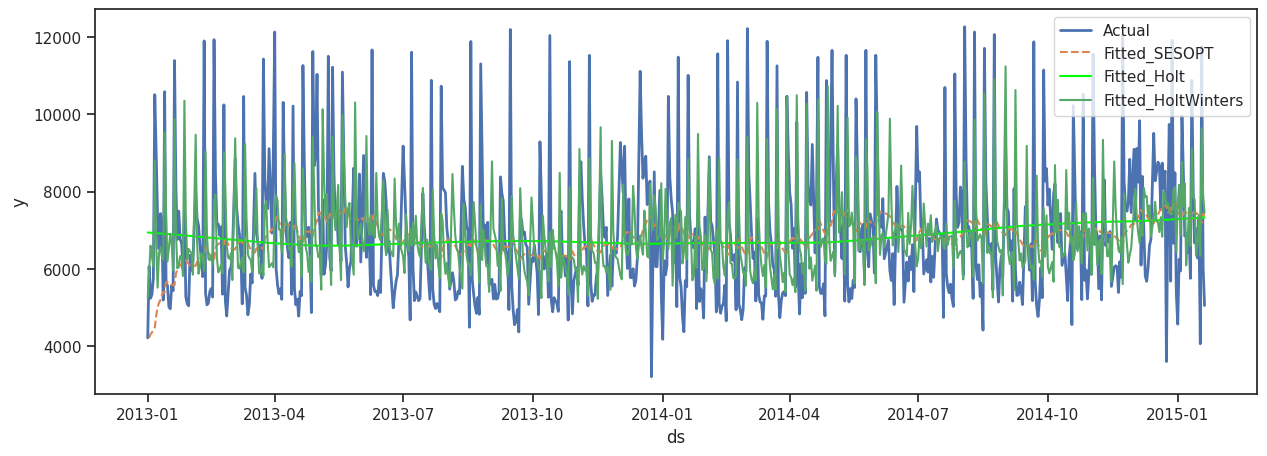

In [67]:
#Plot the actuals vs. fitted values for all SES Optimized, Holt's and Holt-Winter's models
plt.figure(figsize=(15,5))

#Actual data
sns.lineplot(data=train_df, x="ds", y="y", label="Actual", linewidth=2)

#SES Optimized model fitted values
sns.lineplot(data=fitted_df,x="ds", y="fitted_sesopt", label="Fitted_SESOPT", linestyle="--", )

#Holt's model fitted values
sns.lineplot(data=fitted_df, x="ds", y="fitted_holt", label="Fitted_Holt", color="lime")

#Holt-Winter's model fitted values
sns.lineplot(data=fitted_df, x="ds", y="fitted_holtwinters", label="Fitted_HoltWinters")

In [68]:
#Forecast
Y_hat = sf.forecast(h=horizon, fitted=True)
Y_hat.head()

ds  Average   Naive        Drift  Seasonal Naive  \
unique_id                                                            
1         2015-01-21  6888.25  5057.0  5058.177246          7048.0   
1         2015-01-22  6888.25  5057.0  5059.354492          6284.0   
1         2015-01-23  6888.25  5057.0  5060.531738          7343.0   
1         2015-01-24  6888.25  5057.0  5061.708984          4068.0   
1         2015-01-25  6888.25  5057.0  5062.886230         11754.0   

                SESOpt         Holt   HoltWinters        Theta  
unique_id                                                       
1          7239.537109  7336.332031   6542.735352  7211.639160  
1          7239.537109  7338.299316   6510.875977  6823.513672  
1          7239.537109  7340.267090   7358.620605  6796.089355  
1          7239.537109  7342.234375   5633.213379  6781.539062  
1          7239.537109  7344.202148  10261.488281  7176.283203

In [69]:
#See the fitted values
values=sf.forecast_fitted_values()
values.head()

ds       y  Average   Naive        Drift  Seasonal Naive  \
unique_id                                                                    
1         2013-01-01  4220.0  6888.25     NaN          NaN             NaN   
1         2013-01-02  6069.0  6888.25  4220.0  4221.177246             NaN   
1         2013-01-03  5246.0  6888.25  6069.0  6070.177246             NaN   
1         2013-01-04  5339.0  6888.25  5246.0  5247.177246             NaN   
1         2013-01-05  5774.0  6888.25  5339.0  5340.177246             NaN   

                SESOpt         Holt  HoltWinters        Theta  
unique_id                                                      
1                  NaN  6945.758301  5269.573242  4482.803223  
1          4220.000000  6942.673828  5904.596191  2465.541992  
1          4315.150879  6939.687012  6605.155762  2853.623047  
1          4363.052734  6936.448730  6317.807617  3081.121582  
1          4413.275391  6933.060059  6069.107910  3288.924561

In [70]:
Y_hat=Y_hat.reset_index()
Y_hat.head()

unique_id         ds  Average   Naive        Drift  Seasonal Naive  \
0         1 2015-01-21  6888.25  5057.0  5058.177246          7048.0   
1         1 2015-01-22  6888.25  5057.0  5059.354492          6284.0   
2         1 2015-01-23  6888.25  5057.0  5060.531738          7343.0   
3         1 2015-01-24  6888.25  5057.0  5061.708984          4068.0   
4         1 2015-01-25  6888.25  5057.0  5062.886230         11754.0   

        SESOpt         Holt   HoltWinters        Theta  
0  7239.537109  7336.332031   6542.735352  7211.639160  
1  7239.537109  7338.299316   6510.875977  6823.513672  
2  7239.537109  7340.267090   7358.620605  6796.089355  
3  7239.537109  7342.234375   5633.213379  6781.539062  
4  7239.537109  7344.202148  10261.488281  7176.283203

In [71]:
#Get the actual values of forecast duration
actual_ts = test_df["y"]

#Create a list with the model aliases
model_names = [str(model) for model in models]

#Initialize error dataframe
error_df = pd.DataFrame(columns=model_names, index=["MAE","MAPE","MSE","RMSE"])

#Print the errors for each model
for model in model_names:

    #Evaluate the model MAE
    model_mae = np.round(mean_absolute_error(actual_ts, Y_hat[model]),2)

    #Evaluate the model MAPE
    model_mape = np.round(100*mean_absolute_percentage_error(actual_ts, Y_hat[model]),2)

    #Evaluate the model MSE
    model_mse = np.round(mean_squared_error(actual_ts, Y_hat[model]),2)

    #Evaluate the model RMSE
    model_rmse = np.round(np.sqrt(mean_squared_error(actual_ts, Y_hat[model])),2)

    #Save errors in error dataframe
    error_df.loc[:,model] = (model_mae, model_mape, model_mse, model_rmse)

In [72]:
'''
Runs in jupyter notebook

#Create a new column saying which method performed the best, for each evaluation metric
error_df['Best model'] = error_df.idxmin(axis=1)

'''

"\nRuns in jupyter notebook\n\n#Create a new column saying which method performed the best, for each evaluation metric\nerror_df['Best model'] = error_df.idxmin(axis=1)\n\n"

In [73]:
error_df

Average       Naive       Drift Seasonal Naive      SESOpt  \
MAE      1334.54     2051.44     1958.84        2334.43     1416.85   
MAPE       18.09        25.2       23.91          32.33        20.2   
MSE   3261305.11  7330774.84  6905050.15      9714148.9  3247359.39   
RMSE     1805.91     2707.54     2627.75        3116.75     1802.04   

           Holt HoltWinters       Theta  
MAE     1501.38     1798.73     1384.69  
MAPE      22.13       25.24       19.25  
MSE   3397656.7   5777752.1  3305652.23  
RMSE    1843.27      2403.7     1818.15

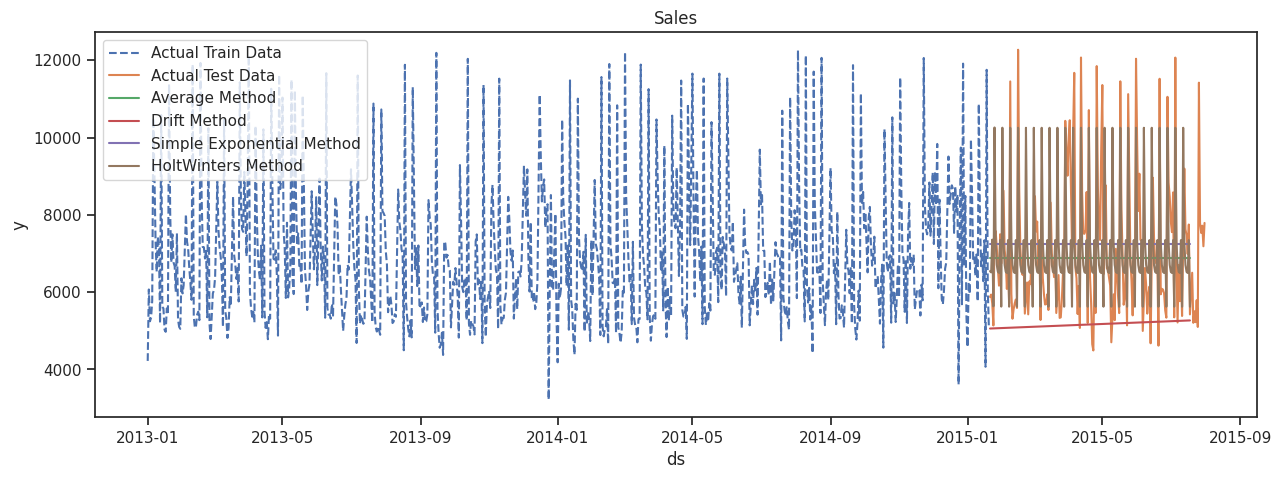

In [74]:
#Plot training and testing data using Seaborn
plt.figure(figsize=(15,5))
sns.lineplot(data=train_df,x="ds", y="y", label="Actual Train Data", linestyle="--")
sns.lineplot(data=test_df, x="ds", y="y", label="Actual Test Data")
sns.lineplot(data=Y_hat, x="ds", y="Average", label="Average Method")
#sns.lineplot(data=Y_hat, x="ds", y="Naive", label="Naive method")
sns.lineplot(data=Y_hat, x="ds", y="Drift", label="Drift Method")
#sns.lineplot(data=Y_hat, x="ds", y="Seasonal Naive", label="Seasonal Naive Method")
sns.lineplot(data=Y_hat, x="ds", y="SESOpt", label="Simple Exponential Method")
#sns.lineplot(data=Y_hat, x="ds", y="Holt", label="Holt Method")
sns.lineplot(data=Y_hat, x="ds", y="HoltWinters", label="HoltWinters Method")
#sns.lineplot(data=Y_hat, x="ds", y="Theta", label="Theta Method")
plt.title("Sales");
plt.show()

### **AUTO-ARIMA forecasting, cross validation, evaluation and residual diagnostics**

**Checking stationarity**

In [75]:
#Augmented Dickey Fuller test
adftest = adfuller(sales["y"])
adf_stat = adftest[0]
adf_pval = adftest[1]

In [76]:
#Check result
print("stat = %f, pval = %f" % (adf_stat, adf_pval))

stat = -6.044608, pval = 0.000000


In [77]:
#Final result
if adf_pval > 0.05:
    print("The time series is not stationary at a 5% significance level")
else:
    print("The time series is stationary at a 5% significance level")

The time series is stationary at a 5% significance level


In [78]:
# Fit AutoARIMA using nixtla's statsforecast
model = StatsForecast(df=train_df, models=[AutoARIMA()], freq='D',fallback_model=SeasonalNaive(season_length=7))
model.fit(train_df)

StatsForecast(models=[AutoARIMA])

In [79]:
#Get forecast
arima_forecast = model.forecast(h=len(test_df), level=[80])
arima_forecast

ds    AutoARIMA  AutoARIMA-lo-80  AutoARIMA-hi-80
unique_id                                                          
1         2015-01-21  7109.552734      4801.623535      9417.481445
1         2015-01-22  7109.534180      4801.516602      9417.551758
1         2015-01-23  7109.516113      4801.409668      9417.622070
1         2015-01-24  7109.498047      4801.302734      9417.693359
1         2015-01-25  7109.479492      4801.195801      9417.763672
...              ...          ...              ...              ...
1         2015-07-14  7106.384277      4783.069824      9429.699219
1         2015-07-15  7106.366211      4782.963379      9429.769531
1         2015-07-16  7106.348145      4782.856934      9429.838867
1         2015-07-17  7106.330078      4782.750977      9429.909180
1         2015-07-18  7106.311523      4782.644531      9429.978516

[179 rows x 4 columns]

In [80]:
model_params = model.fitted_[0][0].model_
model_params

{'coef': {'ar1': 0.999997438427598, 'ma1': -1.0088504397803841},
 'sigma2': 3186537.613244514,
 'var_coef': array([[1.61204584e-11, 1.54622614e-08],
        [1.54622614e-08, 4.04432720e-05]]),
 'mask': array([ True,  True]),
 'loglik': -6349.837950562999,
 'aic': 12705.675901125998,
 'arma': (1, 1, 0, 0, 1, 0, 0),
 'residuals': array([ 1.04529879e+03,  1.50910085e+03,  2.17208261e+02,  2.35229184e+02,
         5.70962728e+02,  4.77521786e+03,  2.64160780e+03,  7.15753118e+02,
        -9.78164756e+01,  7.73132935e+02,  4.12897969e+02, -1.46666831e+03,
         3.80287589e+03, -1.24527204e+03, -1.19386549e+03, -1.65161742e+03,
        -1.60138854e+03, -9.23202928e+02, -1.00769741e+03,  4.81721304e+03,
         1.35049461e+03,  2.48379064e+01,  7.32447737e+02, -7.43716038e+00,
        -1.00735326e+02, -7.42824707e+02,  7.62418891e+02, -1.45307126e+03,
        -1.58110695e+03, -1.57538436e+03, -2.42022555e+02, -6.17157419e+02,
        -3.88948462e+02,  1.42506136e+03,  6.83273653e+02,  4.8

**Residual Diagnostics**

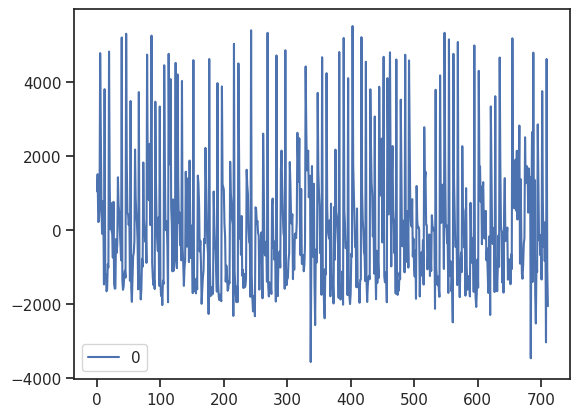

In [81]:
#Residual analysis
residuals = pd.DataFrame(model_params["residuals"])
residuals.plot()
plt.show()

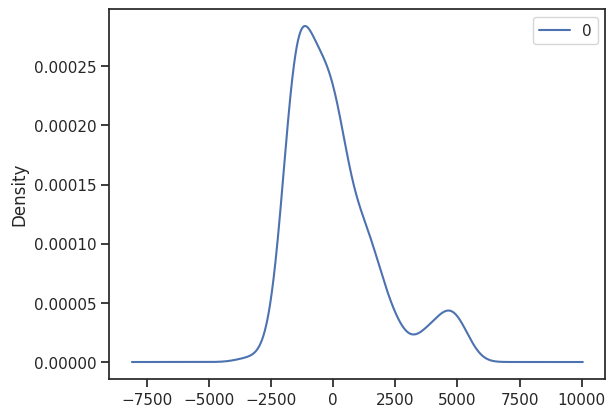

In [82]:
# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

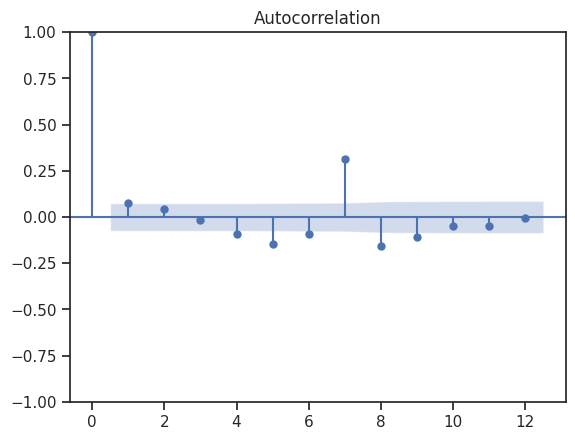

In [83]:
#Plot Autocorrelation of Residuals
plot_acf(residuals, lags=12)
plt.show()

In [84]:
# Summary statistics of residuals
print(residuals.describe())

                 0
count   712.000000
mean     74.027028
std    1782.292943
min   -3559.878201
25%   -1259.521250
50%    -327.014312
75%     839.086198
max    5507.105102


Result of residual diagnostics:
1. The mean of residuals is not 0
2. There are no autocorrelations in residuals
3. The residuals are almost normally distributed
4. They have constant variance

In [85]:
# Aligning the forecast with the test index
Y_hat["Auto_arima"] = arima_forecast['AutoARIMA'].values

**Evaluation**

In [86]:
# Calculate MAPE for ARIMA
mape_arima = np.round(100*mean_absolute_percentage_error(test_df["y"], Y_hat["Auto_arima"]),2)

In [87]:
mape_arima

19.31

**Cross validation**

In [88]:
# Time Series Split
val_size = 30
tscv = TimeSeriesSplit(n_splits=3, test_size=val_size)
mape_values = []
e_values = []

for train_index, test_index in tscv.split(sales):
    train = sales.iloc[train_index]
    test = sales.iloc[test_index]

    # Train the AutoARIMA model
    model = StatsForecast(df=train, models=[AutoARIMA()], freq='D',fallback_model=SeasonalNaive(season_length=4))
    model.fit(train_df)

    forecast_df = model.forecast(h=len(test), level=[80])

    # Evaluate the model (using MAPE and custom error)
    y_true = test['y'].values
    y_pred = forecast_df["AutoARIMA"].values
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate the percentage of points outside the prediction interval
    is_outside_interval = (test['y'] < forecast_df['AutoARIMA-lo-80'].values) | (test['y'] > forecast_df['AutoARIMA-hi-80'].values)
    percentage_outside = (is_outside_interval.mean()) * 100
    print(f"Percentage of points outside the prediction interval: {percentage_outside:.2f}%")

    # Store metrics
    mape_values.append(mape)
    e_values.append(percentage_outside)

    print(f"MAPE for this fold: {mape:.2f}%")
    print("-"*40)

# Calculate and print overall metrics
overall_mape = np.mean(mape_values)
overall_e = np.mean(e_values)

print(f"\nOverall MAPE: {overall_mape:.2f}%")
print(f"\nOverall percentage_outside: {overall_e:.2f}%")

Percentage of points outside the prediction interval: 20.00%
MAPE for this fold: 19.97%
----------------------------------------
Percentage of points outside the prediction interval: 20.00%
MAPE for this fold: 21.29%
----------------------------------------
Percentage of points outside the prediction interval: 6.67%
MAPE for this fold: 18.55%
----------------------------------------

Overall MAPE: 19.94%

Overall percentage_outside: 15.56%


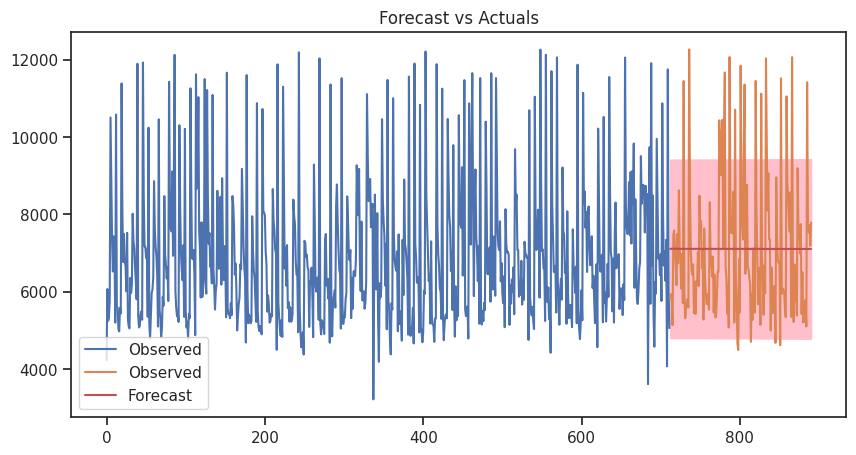

In [89]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train_df["y"], label='Observed')
plt.plot(test_df["y"], label='Observed')
plt.plot(test_df.index,arima_forecast["AutoARIMA"].values, label='Forecast', color='r')
plt.fill_between(test_df.index,
                 arima_forecast['AutoARIMA-lo-80'].values,
                 arima_forecast['AutoARIMA-hi-80'].values, color='pink')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [90]:
Y_hat

unique_id         ds  Average   Naive        Drift  Seasonal Naive  \
0           1 2015-01-21  6888.25  5057.0  5058.177246          7048.0   
1           1 2015-01-22  6888.25  5057.0  5059.354492          6284.0   
2           1 2015-01-23  6888.25  5057.0  5060.531738          7343.0   
3           1 2015-01-24  6888.25  5057.0  5061.708984          4068.0   
4           1 2015-01-25  6888.25  5057.0  5062.886230         11754.0   
..        ...        ...      ...     ...          ...             ...   
174         1 2015-07-14  6888.25  5057.0  5263.012695          5057.0   
175         1 2015-07-15  6888.25  5057.0  5264.189941          7048.0   
176         1 2015-07-16  6888.25  5057.0  5265.367188          6284.0   
177         1 2015-07-17  6888.25  5057.0  5266.544434          7343.0   
178         1 2015-07-18  6888.25  5057.0  5267.721680          4068.0   

          SESOpt         Holt   HoltWinters        Theta   Auto_arima  
0    7239.537109  7336.332031   6542.735352  7211.639160  7109.552734  
1    7239.537109  7338.299316   6510.875977  6823.513672  7109.534180  
2    7239.537109  7340.267090   7358.620605  6796.089355  7109.516113  
3    7239.537109  7342.234375   5633.213379  6781.539062  7109.498047  
4    7239.537109  7344.202148  10261.488281  7176.283203  7109.479492  
..           ...          ...           ...          ...          ...  
174  7239.537109  7678.686523   6703.687988  7384.442871  7106.384277  
175  7239.537109  7680.654297   6524.136230  7211.639160  7106.366211  
176  7239.537109  7682.621582   6495.984863  6823.513672  7106.348145  
177  7239.537109  7684.589355   7346.698730  6796.089355  7106.330078  
178  7239.537109  7686.556641   5623.668457  6781.539062  7106.311523  

[179 rows x 11 columns]

### **SARIMA forecasting, cross validation and evaluation**

In [91]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.4 MB/s eta 0:00:00


In [92]:
import pmdarima as pm

**Finding the suitable parameter values for (p,d,q)(P,D,Q)[7]**

In [93]:
auto_arima_model = pm.auto_arima(train_df["y"], seasonal=True, m=7, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=8.73 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12694.959, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=12661.833, Time=2.82 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=12641.149, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14654.095, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=12692.921, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=12576.703, Time=1.32 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=12578.708, Time=5.60 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=12583.780, Time=1.43 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=12576.504, Time=1.98 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=12640.971, Time=0.98 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=12585.704, Time=6.68 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=7.44 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   :

**Training SARIMA model based on above given parameters**

(179,) (179,)


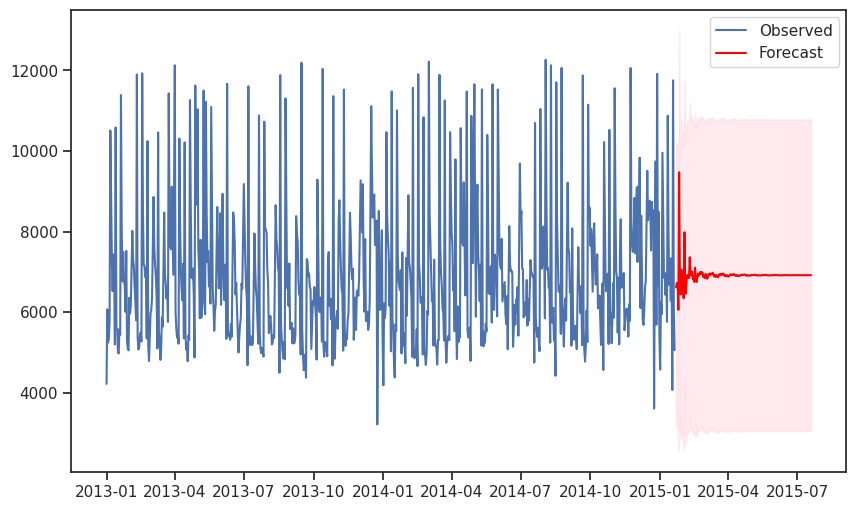

In [94]:
# Forecasting
auto_arima_forecast, conf_int = auto_arima_model.predict(n_periods=len(test_df), return_conf_int=True)

# Plotting the forecast
plt.figure(figsize=(10,6))
plt.plot(train_df["ds"],train_df['y'], label='Observed')
forecast_index = pd.date_range(start=test_df.iloc[0][0], periods=len(test_df)+1, freq='D')[1:]
print(forecast_index.shape,auto_arima_forecast.shape)
plt.plot(forecast_index, auto_arima_forecast, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

**Evaluation**

In [95]:
np.round(100*mean_absolute_percentage_error(test_df["y"], auto_arima_forecast.values),2)

18.28

**Training SARIMA based on observed parameters from ACF and PACF plots**

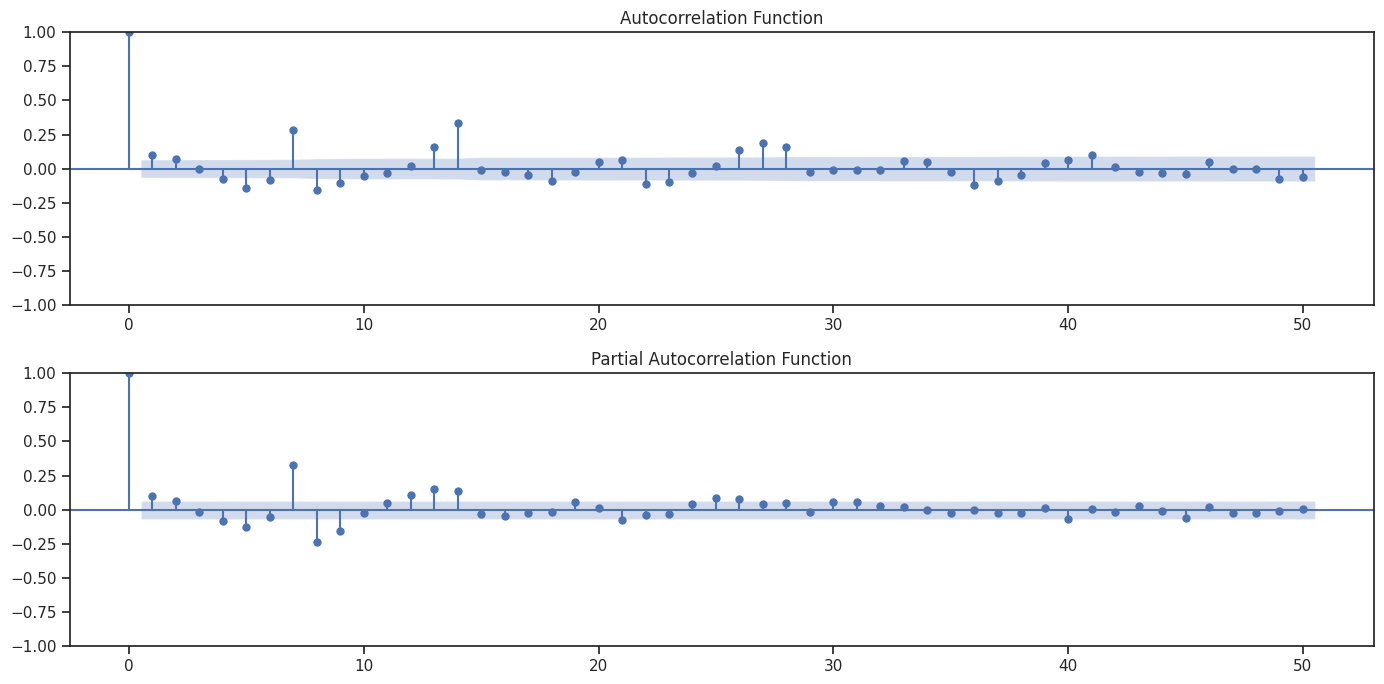

In [96]:
# Plot ACF and PACF
plt.figure(figsize=(14, 7))

plt.subplot(211)
plot_acf(sales['y'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(212)
plot_pacf(sales['y'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [97]:
# Parameters to be defined or found via above ACF and PACF
p, d, q = 2, 0, 2
P, D, Q, s = 2, 0, 2, 7

# Fit SARIMAX model
model = sm.tsa.statespace.SARIMAX(train_df["y"],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

results = model.fit()

# Forecast
forecast = results.get_forecast(steps=len(test_df))
forecast_mean = forecast.predicted_mean

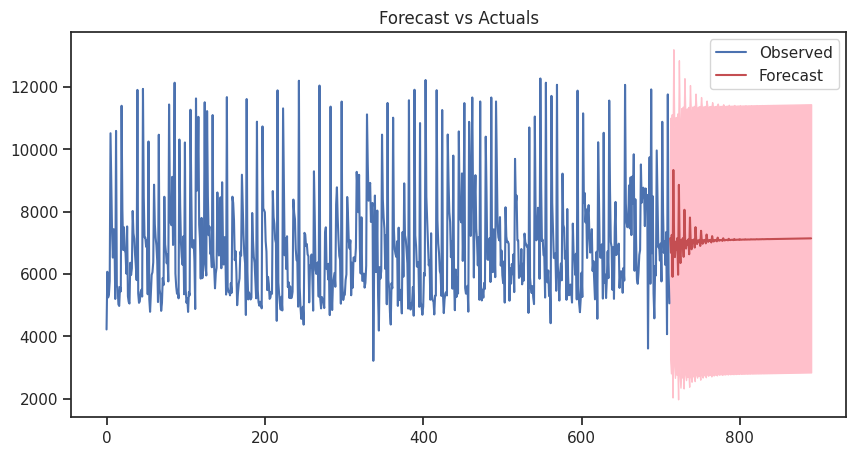

In [98]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train_df["y"], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='r')
plt.fill_between(forecast_mean.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [99]:
Y_hat["AutoSarima"] = forecast_mean.values

**Evaluation**

In [100]:
model_mape = np.round(100*mean_absolute_percentage_error(test_df["y"], Y_hat["AutoSarima"]),2)

In [101]:
model_mape

19.26

**Cross validation**

In [102]:
# Time Series Split
val_size = 40
tscv = TimeSeriesSplit(n_splits=6, test_size=val_size)
mape_values = []
e_values = []

for train_index, test_index in tscv.split(sales):
    train = sales.iloc[train_index]
    test = sales.iloc[test_index]

    # Train the AutoARIMA model
    p, d, q = 2, 0, 2  # Example parameters for ARIMA
    P, D, Q, s = 2, 0, 2, 7  # Example seasonal parameters

    # Fit SARIMA model
    model = sm.tsa.statespace.SARIMAX(train["y"],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    results = model.fit()

    # Define the confidence interval level (e.g., 90%)
    confidence_interval_level = 0.95

    # Get the forecast
    forecast = results.get_forecast(steps=len(test), alpha=1-confidence_interval_level)


    # Evaluate the model (using MAPE and custom error)
    y_true = test['y'].values
    y_pred = forecast.predicted_mean.values
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate the percentage of points outside the prediction interval
    is_outside_interval = (test['y'] < forecast.conf_int()["lower y"].values) | (test['y'] > forecast.conf_int()["upper y"].values)
    percentage_outside = (is_outside_interval.mean()) * 100
    print(f"Percentage of points outside the prediction interval: {percentage_outside:.2f}%")

    # Store metrics
    mape_values.append(mape)
    e_values.append(percentage_outside)

    print(f"MAPE for this fold: {mape:.2f}%")
    print("-"*40)

# Calculate and print overall metrics
overall_mape = np.mean(mape_values)
overall_e = np.mean(e_values)

print(f"\nOverall MAPE: {overall_mape:.2f}%")
print(f"\nOverall percentage_outside: {overall_e:.2f}%")

Percentage of points outside the prediction interval: 5.00%
MAPE for this fold: 19.94%
----------------------------------------
Percentage of points outside the prediction interval: 2.50%
MAPE for this fold: 19.03%
----------------------------------------
Percentage of points outside the prediction interval: 2.50%
MAPE for this fold: 16.71%
----------------------------------------
Percentage of points outside the prediction interval: 12.50%
MAPE for this fold: 21.27%
----------------------------------------
Percentage of points outside the prediction interval: 2.50%
MAPE for this fold: 21.72%
----------------------------------------
Percentage of points outside the prediction interval: 10.00%
MAPE for this fold: 19.38%
----------------------------------------

Overall MAPE: 19.68%

Overall percentage_outside: 5.83%


## **Multivariate Forecasting**

### **SARIMAX forecasting, cross validation and evaluation**

In [153]:
train_temp = temp.copy()
sales_b = train_temp[train_temp.Store == 85][['Sales','Promo']].sort_index(ascending = True)
sales = sales_b.reset_index()
sales.columns = ["ds","y","x"]
#Setting unique_id as 1
sales["unique_id"] = "1"

In [154]:
sales

ds       y  x unique_id
0   2013-01-01  4220.0  0         1
1   2013-01-02  6069.0  0         1
2   2013-01-03  5246.0  0         1
3   2013-01-04  5339.0  0         1
4   2013-01-05  5774.0  0         1
..         ...     ... ..       ...
886 2015-07-27  7788.0  1         1
887 2015-07-28  7533.0  1         1
888 2015-07-29  7719.0  1         1
889 2015-07-30  7187.0  1         1
890 2015-07-31  7791.0  1         1

[891 rows x 4 columns]

In [155]:
# Train-test split (80% train, 20% test)
train_size = int(len(sales) * 0.8)
train_df, test_df = sales[:train_size], sales[train_size:].copy()

In [156]:
# Fit SARIMAX model
p, d, q = 2, 0, 2  # Example parameters for SARIMA
P, D, Q, s = 2, 0, 2, 7  # Example seasonal parameters
model = sm.tsa.statespace.SARIMAX(train_df['y'],
                                  exog=train_df['x'],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

In [157]:
results = model.fit()

# Forecast
forecast = results.get_forecast(steps=len(test_df), exog=test_df['x'])

**Evaluation**

In [158]:
forecast_mean = forecast.predicted_mean

# Calculate MAPE for SARIMAX
mape_sarimax = np.round(100*mean_absolute_percentage_error(test_df["y"], forecast_mean.values),2)

In [159]:
mape_sarimax

57.25

**Cross validation**

In [160]:
# Time Series Split
val_size = 30
tscv = TimeSeriesSplit(n_splits=6, test_size=val_size)
mape_values = []
e_values = []

for train_index, test_index in tscv.split(sales):
    train = sales.iloc[train_index]
    test = sales.iloc[test_index]

    # Train the AutoARIMA model
    p, d, q = 2, 0, 2  # Example parameters for SARIMA
    P, D, Q, s = 2, 0, 2, 7  # Example seasonal parameters
    model = sm.tsa.statespace.SARIMAX(train['y'],
                                  exog=train['x'],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    results = model.fit()

    # Forecast
    forecast = results.get_forecast(steps=len(test), exog=test['x'])


    # Evaluate the model (using MAPE and custom error)
    y_true = test['y'].values
    y_pred = forecast.predicted_mean.values
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate the percentage of points outside the prediction interval
    is_outside_interval = (test['y'] < forecast.conf_int()["lower y"].values) | (test['y'] > forecast.conf_int()["upper y"].values)
    percentage_outside = (is_outside_interval.mean()) * 100
    #print(f"Percentage of points outside the prediction interval: {percentage_outside:.2f}%")

    # Store metrics
    mape_values.append(mape)
    e_values.append(percentage_outside)

    print(f"MAPE for this fold: {mape:.2f}%")
    print("-"*40)

# Calculate and print overall metrics
overall_mape = np.mean(mape_values)
overall_e = np.mean(e_values)

print(f"\nOverall MAPE: {overall_mape:.2f}%")
#print(f"\nOverall percentage_outside: {overall_e:.2f}%")

MAPE for this fold: 51.52%
----------------------------------------
MAPE for this fold: 44.39%
----------------------------------------
MAPE for this fold: 46.38%
----------------------------------------
MAPE for this fold: 50.53%
----------------------------------------
MAPE for this fold: 35.69%
----------------------------------------
MAPE for this fold: 25.73%
----------------------------------------

Overall MAPE: 42.37%


In [161]:
Y_hat["SarimaX"] = forecast_mean.values

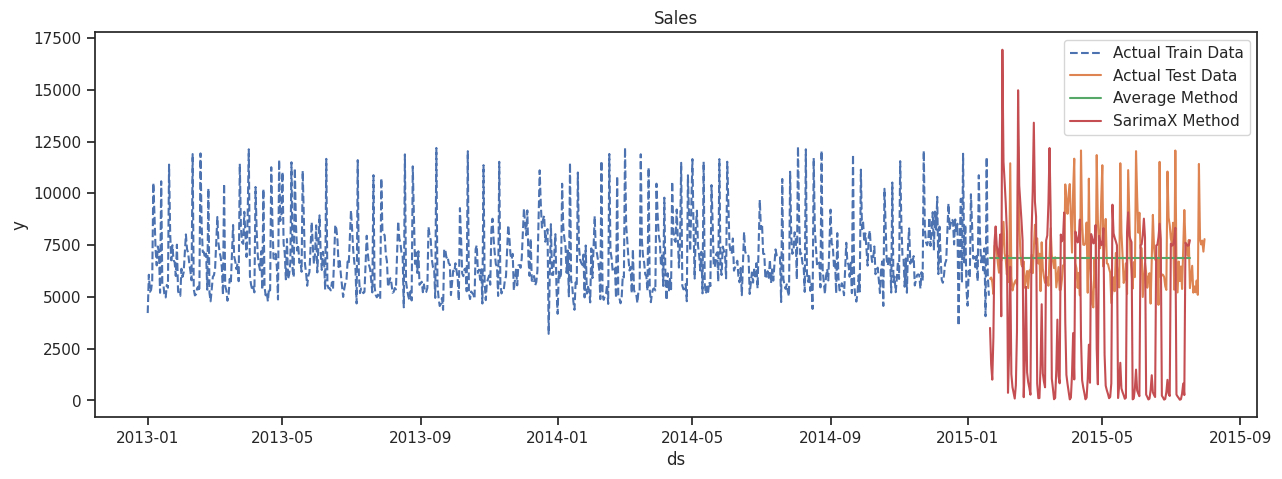

In [162]:
plt.figure(figsize=(15,5))
sns.lineplot(data=train_df,x="ds", y="y", label="Actual Train Data", linestyle="--")
sns.lineplot(data=test_df, x="ds", y="y", label="Actual Test Data")
sns.lineplot(data=Y_hat, x="ds", y="Average", label="Average Method")
sns.lineplot(data=Y_hat, x="ds", y="SarimaX", label="SarimaX Method")
plt.title("Sales");
plt.show()

### **Vector Autoregression forecasting, cross validation, evaluation and residual diagnostics**

In [163]:
#Granger Causality test
gcaustest = grangercausalitytests(sales[["y", "x"]], maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7945  , p=0.1807  , df_denom=887, df_num=1
ssr based chi2 test:   chi2=1.8006  , p=0.1796  , df=1
likelihood ratio test: chi2=1.7987  , p=0.1799  , df=1
parameter F test:         F=1.7945  , p=0.1807  , df_denom=887, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=36.8620 , p=0.0000  , df_denom=884, df_num=2
ssr based chi2 test:   chi2=74.1409 , p=0.0000  , df=2
likelihood ratio test: chi2=71.2111 , p=0.0000  , df=2
parameter F test:         F=36.8620 , p=0.0000  , df_denom=884, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=30.4165 , p=0.0000  , df_denom=881, df_num=3
ssr based chi2 test:   chi2=91.9745 , p=0.0000  , df=3
likelihood ratio test: chi2=87.5166 , p=0.0000  , df=3
parameter F test:         F=30.4165 , p=0.0000  , df_denom=881, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=34.7697 , p=0.0000  

**As the p value is less than 0.05 then we can conclude that there is a causality relationship between the sales column and the promo column**

**Checking stationarity of exogenous variable**

In [164]:
#Augmented Dickey Fuller test
adftest = adfuller(sales["x"])
adf_stat = adftest[0]
adf_pval = adftest[1]

In [165]:
#Check result
print("stat = %f, pval = %f" % (adf_stat, adf_pval))

stat = -7.653383, pval = 0.000000


In [166]:
#Final result
if adf_pval > 0.05:
    print("The time series is not stationary at a 5% significance level")
else:
    print("The time series is stationary at a 5% significance level")

The time series is stationary at a 5% significance level


**Since exogenous variable is stationary hence it can be used for multivariate forecasting**

In [167]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

In [168]:
sales_scaled = pd.DataFrame(scaler.fit_transform(sales[['y', 'x']]), columns=['y', 'x'])

In [169]:
train_size = int(len(sales_scaled) * 0.8)
train_df, test_df = sales_scaled[:train_size], sales_scaled[train_size:]

In [170]:
print(sales_scaled.head())

          y    x
0  0.110952  0.0
1  0.315081  0.0
2  0.224222  0.0
3  0.234489  0.0
4  0.282513  0.0


In [171]:
var_model = VAR(train_df[["y", "x"]].dropna())
var_model.select_order(30).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

**Since AIC for lag 16 is the least hence we will use lag = 16 to fit our model**

In [172]:
#Build model
var_model = VAR(train_df[["y", "x"]].dropna()).fit(16)

In [173]:
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jun, 2024
Time:                     00:54:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.25717
Nobs:                     696.000    HQIC:                  -6.52154
Log likelihood:           418.330    FPE:                 0.00124571
AIC:                     -6.68820    Det(Omega_mle):      0.00113548
--------------------------------------------------------------------
Results for equation y
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.253821         0.048167            5.270           0.000
L1.y          0.104124         0.039623            2.628           0.009
L1.x         -0.057847         0.023192           -2.494           0.013
L2.y          0.126379 

**Residual Diagnostics**

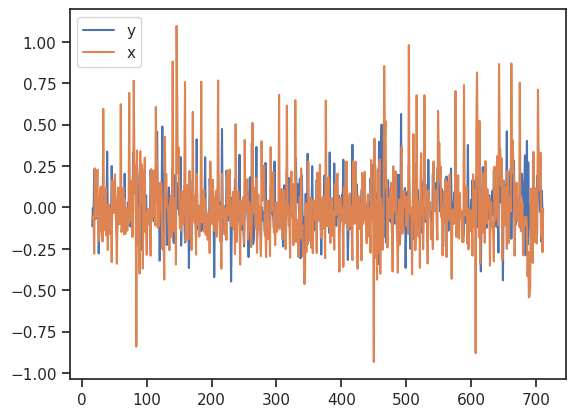

In [174]:
#Residual analysis
residuals = pd.DataFrame(var_model.resid)
residuals.plot()
plt.show()

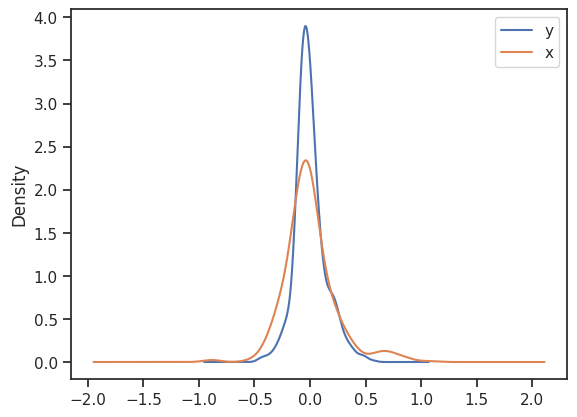

In [175]:
# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

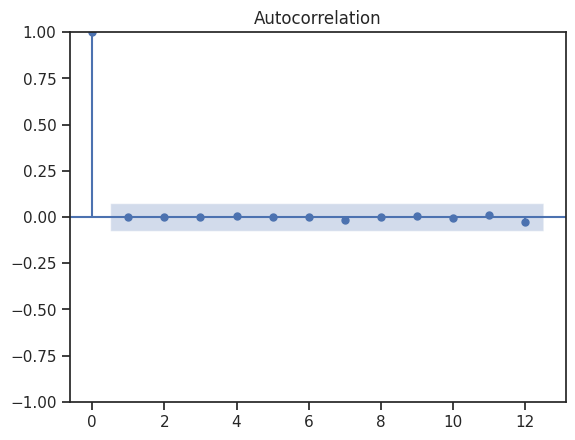

In [176]:
#Plot Autocorrelation of Residuals
plot_acf(residuals["y"], lags=12)
plt.show()

In [177]:
# Summary statistics of residuals
print(residuals.describe())

                  y             x
count  6.960000e+02  6.960000e+02
mean  -5.768055e-16 -4.578713e-15
std    1.387687e-01  2.370185e-01
min   -4.477081e-01 -9.341584e-01
25%   -7.887778e-02 -1.284171e-01
50%   -2.043056e-02 -2.478495e-02
75%    6.106660e-02  9.342367e-02
max    5.634715e-01  1.095469e+00


Result of residual diagnostics:

1. The mean of residuals is 0
2. There are no autocorrelations in residuals
3. The residuals are normally distributed
4. They have constant variance

In [178]:
lag_order = 16
# var_forecast = var_model.forecast(train_df[["y", "x"]].values[-lag_order:],len(test_df))
forecast, lower, upper = var_model.forecast_interval(train_df[["y", "x"]].values[-lag_order:], steps=len(test_df), alpha=0.05)

In [179]:
# var_forecast = var_forecast.reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
lower = scaler.inverse_transform(lower)
upper = scaler.inverse_transform(upper)

In [180]:
forecast_df = pd.DataFrame(forecast, index=test_df.index, columns=['y_forecast', 'x_forecast'])
lower_df = pd.DataFrame(lower, index=test_df.index, columns=['y_lower', 'x_lower'])
upper_df = pd.DataFrame(upper, index=test_df.index, columns=['y_upper', 'x_upper'])

In [183]:
combined_df = pd.concat([forecast_df, lower_df, upper_df], axis=1)
combined_df = combined_df.round(2)

In [184]:
combined_df

y_forecast  x_forecast  y_lower  x_lower   y_upper  x_upper
712     5296.20       -0.09  2773.83    -0.57   7818.56     0.38
713     5673.62       -0.02  3130.84    -0.58   8216.39     0.55
714     5668.74       -0.14  3087.38    -0.74   8250.11     0.46
715     6511.24       -0.10  3906.37    -0.73   9116.12     0.53
716    10098.13        0.33  7486.68    -0.31  12709.58     0.96
..          ...         ...      ...      ...       ...      ...
886     6905.55        0.40  3290.49    -0.58  10520.61     1.39
887     6860.81        0.41  3245.75    -0.58  10475.87     1.40
888     6843.82        0.40  3228.74    -0.59  10458.90     1.39
889     6867.12        0.39  3252.01    -0.60  10482.23     1.38
890     6910.72        0.39  3295.60    -0.60  10525.83     1.37

[179 rows x 6 columns]

In [186]:
test_df_scaled = scaler.inverse_transform(test_df)

test_df_scaled = pd.DataFrame(test_df_scaled, columns=['y', 'x'])

# Round each value in the DataFrame to two decimal places
test_df_scaled = test_df_scaled.round(2)

**Evaluation**

In [187]:
# Calculate MAPE for Vector Autoregression
mape_var = np.round(100*mean_absolute_percentage_error(test_df_scaled["y"], combined_df["y_forecast"].values),2)

In [189]:
mape_var

18.47

In [188]:
is_outside_interval = (test_df_scaled['y'] < combined_df["y_lower"].values) | (test_df_scaled['y'] > combined_df["y_upper"].values)
percentage_outside = (is_outside_interval.mean()) * 100
print(f"Percentage of points outside the prediction interval: {percentage_outside:.2f}%")

Percentage of points outside the prediction interval: 8.94%


**Cross validation**

In [190]:
# Time Series Split
scaler = MinMaxScaler()
sales_scaled = pd.DataFrame(scaler.fit_transform(sales[['y', 'x']]), columns=['y', 'x'])
val_size = 30
tscv = TimeSeriesSplit(n_splits=6, test_size=val_size)
mape_values = []
e_values = []

for train_index, test_index in tscv.split(sales_scaled):
    train = sales_scaled.iloc[train_index]
    test = sales_scaled.iloc[test_index]

    var_model = VAR(train[["y", "x"]].dropna()).fit(16)

    lag_order = 17
    forecast, lower, upper = var_model.forecast_interval(train[["y", "x"]].values[-lag_order:], steps=len(test), alpha=0.05)

    forecast = scaler.inverse_transform(forecast)
    lower = scaler.inverse_transform(lower)
    upper = scaler.inverse_transform(upper)

    forecast_df = pd.DataFrame(forecast, index=test.index, columns=['y_forecast', 'x_forecast'])
    lower_df = pd.DataFrame(lower, index=test.index, columns=['y_lower', 'x_lower'])
    upper_df = pd.DataFrame(upper, index=test.index, columns=['y_upper', 'x_upper'])

    combined_df = pd.concat([forecast_df, lower_df, upper_df], axis=1)
    combined_df = combined_df.round(2)

    test_df_scaled = scaler.inverse_transform(test)
    test_df_scaled = pd.DataFrame(test_df_scaled, columns=['y', 'x'])
    # Round each value in the DataFrame to two decimal places
    test_df_scaled = test_df_scaled.round(2)



    # Evaluate the model (using MAPE and custom error)
    y_true = test_df_scaled['y'].values
    y_pred = combined_df["y_forecast"]
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate the percentage of points outside the prediction interval
    is_outside_interval = (test_df_scaled['y'] < combined_df["y_lower"].values) | (test_df_scaled['y'] > combined_df["y_upper"].values)
    percentage_outside = (is_outside_interval.mean()) * 100
    print(f"Percentage of points outside the prediction interval: {percentage_outside:.2f}%")

    # Store metrics
    mape_values.append(mape)
    e_values.append(percentage_outside)

    print(f"MAPE for this fold: {mape:.2f}%")
    print("-"*40)

# Calculate and print overall metrics
overall_mape = np.mean(mape_values)
overall_e = np.mean(e_values)

print(f"\nOverall MAPE: {overall_mape:.2f}%")
print(f"\nOverall percentage_outside: {overall_e:.2f}%")

Percentage of points outside the prediction interval: 10.00%
MAPE for this fold: 14.95%
----------------------------------------
Percentage of points outside the prediction interval: 3.33%
MAPE for this fold: 15.51%
----------------------------------------
Percentage of points outside the prediction interval: 23.33%
MAPE for this fold: 19.57%
----------------------------------------
Percentage of points outside the prediction interval: 13.33%
MAPE for this fold: 18.42%
----------------------------------------
Percentage of points outside the prediction interval: 10.00%
MAPE for this fold: 17.48%
----------------------------------------
Percentage of points outside the prediction interval: 3.33%
MAPE for this fold: 13.40%
----------------------------------------

Overall MAPE: 16.56%

Overall percentage_outside: 10.56%


### **Prophet Multivariate Model**

In [ ]:
'''#Format data for building Prophet model
prophet_df = train[["ds","y","Open","Promo","SchoolHoliday","unique_id"]]
prophet_df.columns = ["ds","y","Open","Promo","SchoolHoliday","unique_id"]
prophet_df

#Initialize model
prophet_model = Prophet(growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode='additive')
prophet_model.add_regressor("Open")
prophet_model.add_regressor("Promo")
prophet_model.add_regressor("SchoolHoliday")

#Fit the model
prophet_model.fit(prophet_df)

def forecast_exog(exog_var_name, horizon):
    exog_df = prophet_df[exog_var_name].reset_index()
    exog_df.columns = ["ds","y"]
    exog_df["unique_id"] = 1

    #Get forecast of realcons exogenous variable for next 4 quarters using a Drift method
    models = [RandomWalkWithDrift(alias="Drift")]
    sf_exog = StatsForecast(df=exog_df,
                       models=models,
                       freq='D', # quarterly frequency
                       n_jobs=-1)

    forecasted_exog = sf_exog.forecast(horizon)["Drift"].values
    return(forecasted_exog)

future = prophet_model.make_future_dataframe(periods=189, freq="D")
#Added historical actual data of exogenous variables
future.loc[future["ds"] <= "2015-01-24",["Open","Promo","SchoolHoliday"]] = prophet_df.loc[prophet_df["ds"] <= "2015-01-24",["Open","Promo","SchoolHoliday"]]
future

prophet_df.set_index('ds',inplace=True)
forecasted_exog_df = pd.DataFrame()
forecasted_exog_df["ds"] = testdata['ds'] #Set index as ds
forecasted_exog_df["Open"] = forecast_exog("Open",189) #forecasting exogens
forecasted_exog_df["Promo"] = forecast_exog("Promo",189) #forecasting exogens
forecasted_exog_df["SchoolHoliday"] = forecast_exog("SchoolHoliday",189) #forecasting exogens
forecasted_exog_df

future.loc[future["ds"] > "2015-01-23",["Open","Promo","SchoolHoliday"]] =forecasted_exog_df.loc[:,["Open","Promo","SchoolHoliday"]].values
#Make forecasts
prophet_forecast_multi = prophet_model.predict(future)
prophet_forecast_multi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

def root_mean_squared_percentage_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    """
    Calculate Root Mean Squared Percentage Error (RMSPE).

    Parameters:
    - y_true (array-like): Array of true values.
    - y_pred (array-like): Array of predicted values.

    Returns:
    - float: RMSPE value.
    """

y_true=testdata['y']
y_pred=prophet_forecast_multi['yhat'][753:]
error=root_mean_squared_percentage_error(y_true,y_pred)
print(f"Root Mean Squared Percentage Error (RMSPE): {error:.4f}")'''

## **Best Fit Model: Prophet Model**

In [192]:
# importing data
df = pd.read_csv("train.csv", low_memory = False)

In [193]:
#Creating new column 'Outlier' which tells whether a point is outlier or not.
for i in df['Store'].unique():
    df.loc[(df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(df.loc[(df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3.5)

#Removing all the outliers.
df = df.loc[df['Outlier']==False].drop('Outlier', axis=1)

In [194]:
# handling the inconsistencies
print("Days which didn't have any sales won't be counted into the forecasts.")
df = df[(df['Sales'] != 0)]

Days which didn't have any sales won't be counted into the forecasts.


In [195]:
# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

**Forecasting**

In [196]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

ds     y
1014980 2013-01-02  5530
1013865 2013-01-03  4327
1012750 2013-01-04  4486
1011635 2013-01-05  4997
1009405 2013-01-07  7176

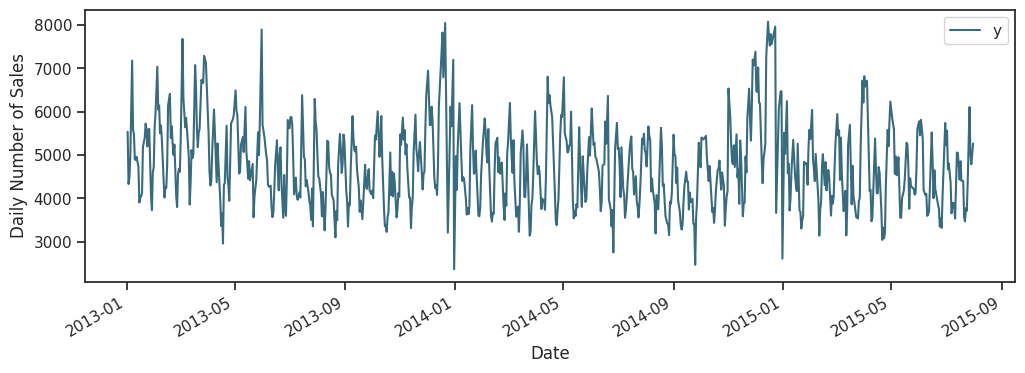

In [197]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [198]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

holiday         ds
0  state_holiday 2015-06-04
1  state_holiday 2015-06-04
2  state_holiday 2015-06-04
3  state_holiday 2015-06-04
4  state_holiday 2015-06-04

In [199]:
# import the Prophet class from the prophet module
from prophet import Prophet

# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95,
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 3 weeks
future_dates = my_model.make_future_dataframe(periods = 3*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/vll_2enu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/vcwwx40c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8909', 'data', 'file=/tmp/tmpnv9reqg0/vll_2enu.json', 'init=/tmp/tmpnv9reqg0/vcwwx40c.json', 'output', 'file=/tmp/tmpnv9reqg0/prophet_modelof7_wwx6/prophet_model-20240621011734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:17:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:17:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


First week to forecast.


ds
790 2015-08-15
791 2015-08-16
792 2015-08-17
793 2015-08-18
794 2015-08-19
795 2015-08-20
796 2015-08-21

In [200]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds         yhat   yhat_lower   yhat_upper
790 2015-08-15  4127.092311  2596.702307  5786.985759
791 2015-08-16  4121.504718  2501.248312  5796.085853
792 2015-08-17  4174.235689  2433.897342  5777.715650
793 2015-08-18  3738.540676  2105.342144  5286.387217
794 2015-08-19  3623.193985  1885.916422  5210.969904
795 2015-08-20  3530.547834  2010.102559  5089.230958
796 2015-08-21  3766.978663  2016.233841  5542.069729

In [201]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

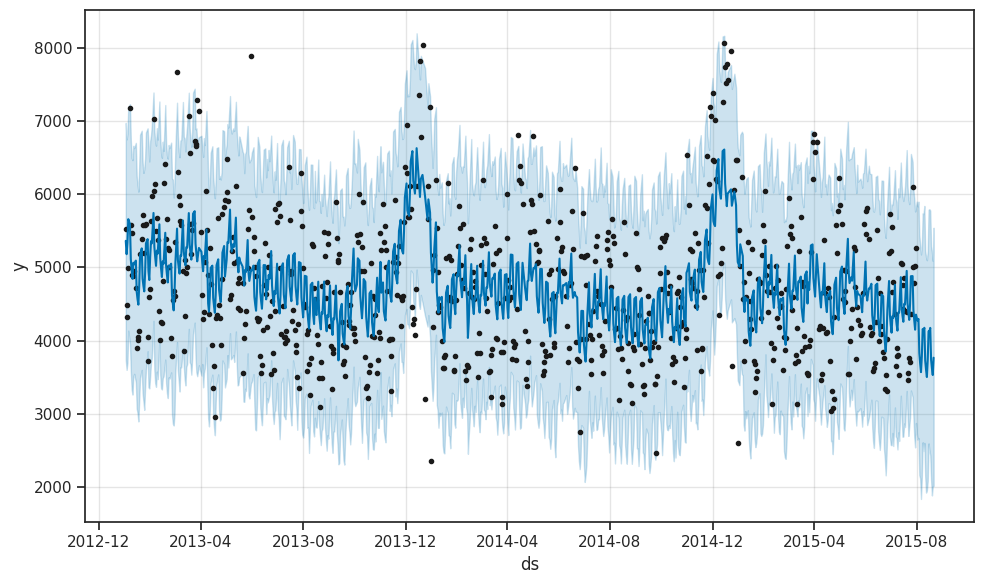

In [202]:
# visualizing predicions
my_model.plot(forecast);

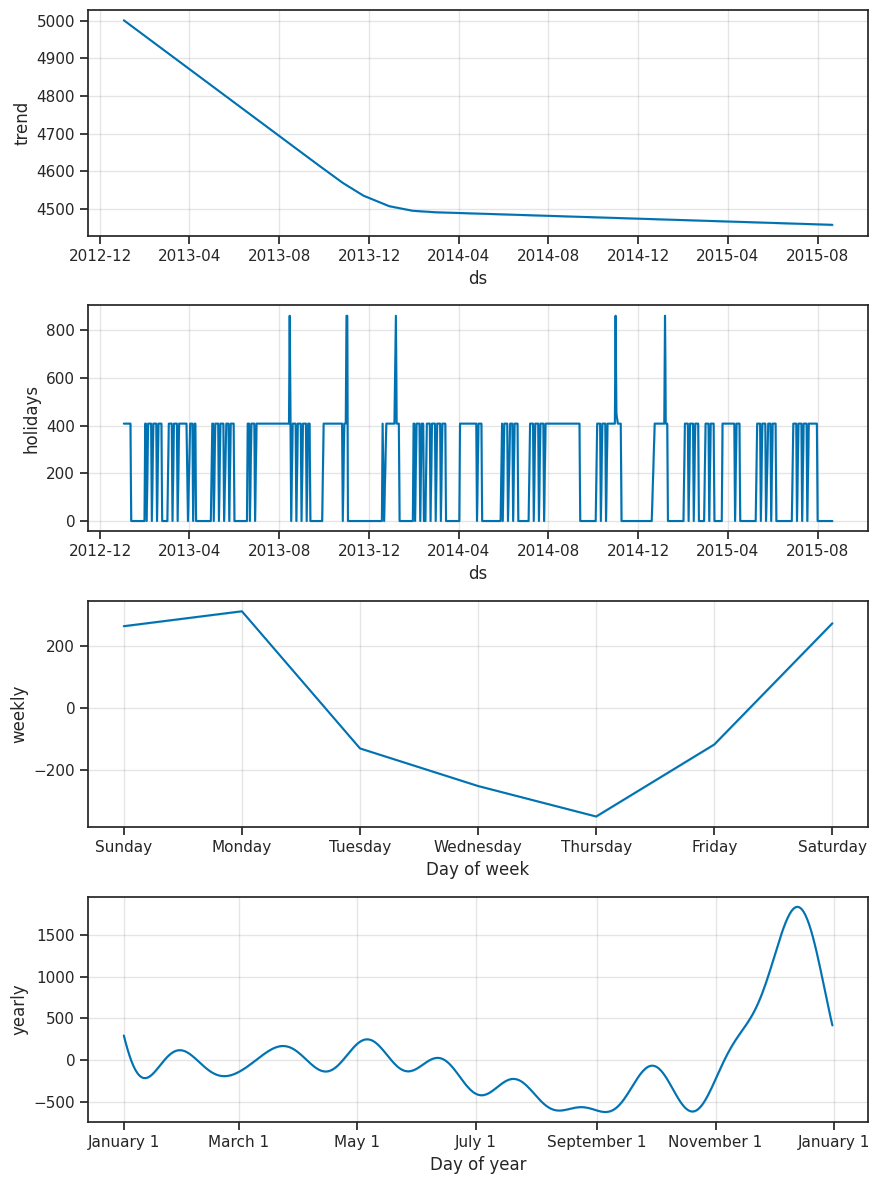

In [203]:
my_model.plot_components(forecast);

**Cross validation and evaluation**

In [204]:
from sklearn.model_selection import TimeSeriesSplit  # For time-series specific cross-validation
from prophet import Prophet

val_size = 30

# Time Series Split
tscv = TimeSeriesSplit(n_splits=6,test_size=val_size)  # Adjust n_splits based on your data and preference
mape_values = []
e_values = []
r = []

for train_index, test_index in tscv.split(sales):
    train = sales.iloc[train_index]
    test = sales.iloc[test_index]

    # Train the model on the training set
    m = Prophet(interval_width=0.95, holidays=holidays)
    m.fit(train)

    # Make predictions on the test set
    future = m.make_future_dataframe(periods=len(test))
    forecast = m.predict(future)

    y_true = test['y'].values
    y_pred = forecast['yhat'].values[-len(test):] # Filter to match the length of the test

    # Evaluate the model (using MAPE as an example)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate the percentage of points outside the prediction interval
    is_outside_interval = (test['y'].values < forecast['yhat_lower'].values[-len(test):]) | (test['y'].values > forecast['yhat_upper'].values[-len(test):])

    # Calculate the percentage only for test data
    percentage_outside = (np.sum(is_outside_interval) / len(test)) * 100
    print(f"Percentage of points outside the prediction interval: {percentage_outside:.2f}%")
    e_values.append(float(f"{percentage_outside:.2f}"))

    # Store MAPE for this fold
    mape_values.append(mape)

    print(f"MAPE for this fold: {mape:.2f}%")

# Optionally: retrain on the full dataset if needed
final_model = Prophet(interval_width=0.95, holidays=holidays)
final_model.fit(sales)

# Calculate and print overall MAPE
overall_mape = np.mean(mape_values)
overall_e = np.mean(e_values)

print(f"\nOverall MAPE: {overall_mape:.2f}%")
print(f"\nOverall custom_error: {overall_e:.2f}%")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/uvmjre46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/8hy53yj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57369', 'data', 'file=/tmp/tmpnv9reqg0/uvmjre46.json', 'init=/tmp/tmpnv9reqg0/8hy53yj1.json', 'output', 'file=/tmp/tmpnv9reqg0/prophet_modelvy0puhjh/prophet_model-20240621012037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:20:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality

Percentage of points outside the prediction interval: 6.67%
MAPE for this fold: 24.62%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/lybt7me0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/50afkr1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9947', 'data', 'file=/tmp/tmpnv9reqg0/lybt7me0.json', 'init=/tmp/tmpnv9reqg0/50afkr1q.json', 'output', 'file=/tmp/tmpnv9reqg0/prophet_modelhsvb_thr/prophet_model-20240621012207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:22:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:22:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Percentage of points outside the prediction interval: 10.00%
MAPE for this fold: 16.97%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/co52rcar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/9nt6r4xo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6518', 'data', 'file=/tmp/tmpnv9reqg0/co52rcar.json', 'init=/tmp/tmpnv9reqg0/9nt6r4xo.json', 'output', 'file=/tmp/tmpnv9reqg0/prophet_modelqsucsetz/prophet_model-20240621012315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:23:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Percentage of points outside the prediction interval: 13.33%
MAPE for this fold: 23.41%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/38qor63_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/pcv0c8lb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81834', 'data', 'file=/tmp/tmpnv9reqg0/38qor63_.json', 'init=/tmp/tmpnv9reqg0/pcv0c8lb.json', 'output', 'file=/tmp/tmpnv9reqg0/prophet_modelp7bafnfh/prophet_model-20240621012500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:25:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Percentage of points outside the prediction interval: 3.33%
MAPE for this fold: 15.80%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/ilnj90tq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/6snz9nf8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19235', 'data', 'file=/tmp/tmpnv9reqg0/ilnj90tq.json', 'init=/tmp/tmpnv9reqg0/6snz9nf8.json', 'output', 'file=/tmp/tmpnv9reqg0/prophet_modelfd3hofxx/prophet_model-20240621012605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:26:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:26:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Percentage of points outside the prediction interval: 0.00%
MAPE for this fold: 16.50%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/kir207n1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/0r5z8ikm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49480', 'data', 'file=/tmp/tmpnv9reqg0/kir207n1.json', 'init=/tmp/tmpnv9reqg0/0r5z8ikm.json', 'output', 'file=/tmp/tmpnv9reqg0/prophet_modela3rpeilj/prophet_model-20240621012747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:27:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:27:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Percentage of points outside the prediction interval: 3.33%
MAPE for this fold: 14.11%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/6s6cxr28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv9reqg0/acwnyqsq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44538', 'data', 'file=/tmp/tmpnv9reqg0/6s6cxr28.json', 'init=/tmp/tmpnv9reqg0/acwnyqsq.json', 'output', 'file=/tmp/tmpnv9reqg0/prophet_modelgn1iv84g/prophet_model-20240621012853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:28:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:28:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Overall MAPE: 18.57%

Overall custom_error: 6.11%


**Analyzing change points in the dataset**

In [205]:
# Access changepoints
changepoints = my_model.changepoints

# Print the changepoints
print(changepoints)

25    2013-01-31
50    2013-03-01
74    2013-03-30
99    2013-04-30
124   2013-06-03
149   2013-07-02
173   2013-07-30
198   2013-08-28
223   2013-09-26
248   2013-10-26
272   2013-11-23
297   2013-12-28
322   2014-01-28
347   2014-02-26
371   2014-03-26
396   2014-04-26
421   2014-05-27
446   2014-06-28
470   2014-07-26
495   2014-08-25
520   2014-09-23
545   2014-10-23
569   2014-11-20
594   2014-12-19
619   2015-01-23
Name: ds, dtype: datetime64[ns]


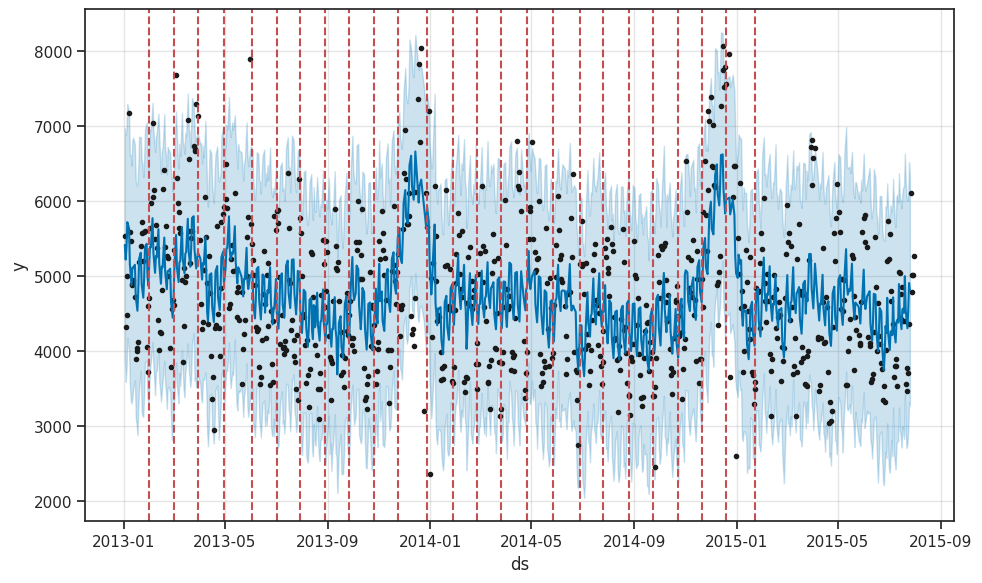

In [206]:
fig = my_model.plot(forecast)
for changepoint in changepoints:
    plt.axvline(x=changepoint, color='r', linestyle='--')

plt.show()